In [ ]:
import numpy as np
import pandas as pd
from scipy.integrate import trapezoid
from scipy.integrate import cumulative_trapezoid
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import seaborn as sns
import pandas_datareader.data as web
import yfinance as yf
from numpy.random import default_rng

In [ ]:
#np.random.seed(42)


#Setting up the functions

$\theta(t)
\;=\;
f'(0,t)
\;+\;
a\,f(0,t)
\;+\;
\frac{\sigma^2}{2a}\,\bigl(1 - e^{-2a t}\bigr)$

$and\$

$
f(0,t)
=
-\frac{\partial}{\partial t}\ln P(0,t)
\;\Longrightarrow\;
f(0,t)=r(t) + tr'(t).
$

$This\ derives\ from\ the\ price\ of\ a\ zero\ coupon\ bond\ computed\ as\ P(0,t) = e^{-r(t)\,t} \Longrightarrow\ ln P(0,t)=-r(t)t\\ and\ the\ exploitation\ of\ the\ product\ rules\ f(t)
= -\frac{\mathrm{d}}{\mathrm{d}t}\bigl[-r(t)\,t\bigr]
= r(t) + t\,r'(t)$

$where$

$f'(0,t) = \frac{d}{dt}\left[ r(t) + tr'(t) \right]
         = r'(t) + \left[ r'(t) + tr''(t) \right]
         = 2r'(t) + tr''(t)$


In [ ]:
def theta_fit(Times,IR,alfa,sigma,T,dt):
  t_inter=np.linspace(0,T,int(T/dt)+1)

  spline=CubicSpline(Times,IR,bc_type='natural')
  rates_inter=spline(t_inter)
  rate_prime=spline.derivative(1)(t_inter)
  rate_double_prime=spline.derivative(2)(t_inter)

  fwd_rate= rates_inter+t_inter*rate_prime
  fwd_prime=2*rate_prime+t_inter*rate_double_prime

  thetas=fwd_prime+alfa*fwd_rate+(sigma**2/(2*alfa))*(1-np.exp(-2*alfa*t_inter))

  return thetas,fwd_rate

$\begin{align}
xi_n &\sim \mathcal{N}(0,1), \\
r_{n+1}
&= r_n
  + \bigl(\theta(t_n) - a_d\,r_n\bigr)\,\Delta t
  + \sigma_d\,\sqrt{\Delta t}\,\xi_n.
\end{align}$

In [ ]:
def H_W(R0,thetas,alfa,sigma,T,dt,n_path,seed):
  rng = default_rng(seed)
  rates=np.zeros((n_path,int(T/dt)+1))
  rates[:,0]=R0
  for i in range(1,int(T/dt)+1):
    rates[:,i]=rates[:,i-1]+(thetas[i-1]-alfa*rates[:,i-1])*dt+sigma*np.sqrt(dt)*rng.normal(0,1,n_path)
  return rates

In [ ]:
def swap_fixed_rate(disc_factors,t,payments_dates):
  tau=payments_dates[1]-payments_dates[0]
  initial=np.searchsorted(payments_dates,t, side='left')
  fixed_leg=0
  fixed_leg=np.sum(disc_factors[initial+1:]*tau)

  return (disc_factors[0]-disc_factors[-1])/fixed_leg

$\begin{aligned}
&RFS(0)=N \sum_{\alpha+1}^{\beta} \tau_i K P(0, T_i) - N P(0, T_{\alpha}) + N P(0, T_{\beta})
\end{aligned}$

In [ ]:
def swap_price_func(disc_factors,K,t,payments_dates):
  tau=payments_dates[1]-payments_dates[0]
  fixed_leg=0
  initial=np.searchsorted(payments_dates,t, side='left')

  for i in range(initial+1,len(payments_dates)):
    fixed_leg+=K*disc_factors[i]*tau

  first_discout_factor=disc_factors[initial]
  last_discount_factor=disc_factors[-1]

  swap_price=fixed_leg-first_discout_factor+last_discount_factor
  return swap_price

$
P(t, T) = A(t, T) \, e^{-B(t,T)\, r_d(t)}
$

$where:$

$
A(t, T) = \frac{P^M(0, T)}{P^M(0, t)} \exp \left\{ B(t, T) f^M(0, t) - \frac{\sigma^2}{4a} \left(1 - e^{-2a t} \right) B(t, T)^2 \right\}
$

$
B(t, T) = \frac{1}{a} \left( 1 - e^{-a(T - t)} \right)
$



In [ ]:
def BondPrices(sigma,alfa,IR,rates,last_t,initial_t,times):
  idx_initial=min(np.searchsorted(times,initial_t,side='left'),len(IR)-1)
  idx_final=min(np.searchsorted(times,last_t,side='left'),len(IR)-1)
  P=0

  #fwd=IR[idx_initial]+initial_t*np.gradient(IR,times)[idx_initial]
  cs = CubicSpline(times, IR)
  fwd = cs(initial_t) + initial_t * cs.derivative(1)(initial_t)

  P_T=np.exp(-IR[idx_final]*last_t)
  P_t=np.exp(-IR[idx_initial]*initial_t)

  B=(1/alfa)*(1-np.exp(-alfa*(last_t-initial_t)))
  A=(P_T/P_t)*np.exp(B*fwd-sigma**2/(4*alfa)*(1-np.exp(-2*alfa*initial_t))*B**2)
  P=A*np.exp(-B*rates[idx_initial])

  return P

$
\begin{aligned}
&RFS(t)=N \sum_{\alpha+1}^{\beta} \tau_i K P(t, T_i) - N P(t, T_{\alpha}) + N P(t, T_{\beta})
\end{aligned}
$

In [ ]:
def MtM_fun(alfa,sigma,IR,rates,K,times):
  tau=times[1]-times[0]
  mtm=np.zeros(rates.shape)

  for i in range(rates.shape[0]):
    for t in range(1,len(times)):
      P_alfa=BondPrices(sigma,alfa,IR,rates[i,:],times[t],times[t],times)
      P_beta=BondPrices(sigma,alfa,IR,rates[i,:],times[-1],times[t],times)
      fixed_leg=0
      for k in range(1,len(times)-t):
        P=BondPrices(sigma,alfa,IR,rates[i,:],times[t+k],times[t],times)
        fixed_leg+=K*P*tau
      mtm[i,t]=fixed_leg-P_alfa+P_beta
  return mtm

$For\ the\ fx\ rate\ I\ opted\ for\ a\ GBM\ because\ it\ does\ not\ allow\ for\ negative\ rates$

In [ ]:
def GBM_fx(fx,mu,sigma,T,dt,n_path):
  rates=np.zeros((n_path,int(T/dt)+1))
  rates[:,0]=fx
  for i in range(1,int(T/dt)+1):
    rates[:,i]=rates[:,i-1]*np.exp((mu-sigma**2/2)*dt+sigma*np.sqrt(dt)*np.random.normal(0,1,n_path))
  return rates

In [ ]:
def fx_correlated(R0_eur,R0_USD,theta_EUR,theta_USD,fx_0,corrmatrix,sigma_fx,mu_fx,sigma_eur,alfa_eur,alfa_usd,sigma_usd,T,dt,n_path,seed):
  rates_eur=np.zeros((n_path,int(T/dt)+1))
  rates_usd=np.zeros((n_path,int(T/dt)+1))
  fx_rates=np.zeros((n_path,int(T/dt)+1))
  fx_rates[:,0]=fx_0
  rates_eur[:,0]=R0_eur
  rates_usd[:,0]=R0_USD

  L=np.linalg.cholesky(corrmatrix)
  rng = default_rng(seed)
  for t in range(1,int(T/dt)+1):
    Z=rng.normal(0,1,size=(3,n_path))
    dw=L@Z

    rates_eur[:,t]=rates_eur[:,t-1]+(theta_EUR[t-1]-alfa_eur*rates_eur[:,t-1])*dt+sigma_eur*np.sqrt(dt)*dw[0]#dw0 random eur shock of containing correlation with usd and fx
    rates_usd[:,t]=rates_usd[:,t-1]+(theta_USD[t-1]-alfa_usd*rates_usd[:,t-1])*dt+sigma_usd*np.sqrt(dt)*dw[1]#dw1 random usd shocks containing the correlation with eur and fx

    drift_fx=rates_eur[:,t-1]-rates_usd[:,t-1]#in this way I am trying to reflect the no arbitrage relationship that governs the interest rates and forex exchange rates
    fx_rates[:,t]=fx_rates[:,t-1]*np.exp((drift_fx-0.5*sigma_fx**2)*dt+sigma_fx*np.sqrt(dt)*dw[2])#dw2 random fx shocks containing the correlation with eur and usd
    #fx_rates[:,t]=np.clip(fx_rates[:,t-1]*np.exp((drift_fx-0.5*sigma_fx**2)*dt+sigma_fx*np.sqrt(dt)*dw[2]),0.959619,1.234111)#dw2 random fx shocks containing the correlation with eur and usd,
    #np.clip allows to cap the range of the exchage rate between the minimum and maximum observed exchange rate in the period
  return pd.DataFrame(rates_eur),pd.DataFrame(rates_usd),pd.DataFrame(fx_rates)

In [ ]:
def leg_npv(IR6m,sim_rates,current_time_index,times,sigma,alfa):
    tau=times[1]-times[0]
    npv=0.0
    t= times[current_time_index]

    for k in range(current_time_index + 1, len(times)):
        #P = BondPrices(sigma, alfa, discount_curve, sim_rates, times[k], t, times)#def BondPrices(sigma,alfa,IR,rates,last_t,initial_t,times):
        #float_rate = sim_rates[k-1]
        #npv += float_rate * P * dt
        P_Tk_1=BondPrices(sigma,alfa,IR6m,sim_rates,times[k-1],t,times)
        P_Tk=BondPrices(sigma,alfa,IR6m,sim_rates,times[k],t,times)
        float_rate=1/tau*(P_Tk_1/P_Tk-1)
        npv+=float_rate*tau*P_Tk

    return npv

$Present\ value\ of\ a\ USD\ leg\ in\ EUR\$

$
\text{PV}^{\text{EUR}}(t)
= \sum_{k:\,T_k>t}
\left[
\left(
\frac{P_{\text{USD}}(t,T_{k-1})}{P_{\text{USD}}(t,T_k)} - 1
\right)
\tau
\times
\frac{P_{\text{EUR}}(t,T_k)}{F_{t,T_k}}
\right]
$

$F_{t,T_k} = S_t \frac{P_{\mathrm{USD}}(t,T_k)}{P_{\mathrm{EUR}}(t,T_k)} →$
$\frac{P_{\mathrm{EUR}}(t,T_k)}{F_{t,T_k}} = \frac{P_{\mathrm{USD}}(t,T_k)}{S_t}\ (because\ of\ covered\ interest\ rate\ parity)$


In [ ]:
'''The variable sim_rates and times are referred to the 6months rates extracted from the daily rates and the payments date every 6months'''
def leg_npvusd_in_eur(IR6m,IR6m_usd,sim_rates,sim_rates_usd,current_time_index,times,sigma,alfa,sigma_usd,alfa_usd,fx_path):
    tau=times[1]-times[0]
    t= times[current_time_index]#current time index is refererred to the six month time not the daily one
    npv=0.0
    for k in range(current_time_index +1, len(times)):
      P_Tk_eur=BondPrices(sigma,alfa,IR6m,sim_rates,times[k],t,times)#EURO DISCOUNT FACTOR P(t,T_k)
      P_Tk=BondPrices(sigma_usd,alfa_usd,IR6m_usd,sim_rates_usd,times[k],t,times)#USD DISCOUNT FACTOR P(t,T_K)
      P_TK_1=BondPrices(sigma_usd,alfa_usd,IR6m_usd,sim_rates_usd,times[k-1],t,times)#USD DISCOUNT FACTOR P(t,T_K-1)

      float_rate=1/tau*(P_TK_1/P_Tk-1)#Float USD rate
      fwd_tk= fx_path[current_time_index]*P_Tk/P_Tk_eur#Forward EURUSD (1EUR=XXXUSD)

      npv += float_rate*tau*(P_Tk_eur/fwd_tk)
    return npv

In [ ]:
''' What i am passing in rates,fx_paths and times are the value extracted every six months not the daily ones'''
def xccy_mtm_exc(rates_EUR,rates_USD,fx_paths,times,IR6m,IR6m_usd,sigma,alfa,sigma_usd,alfa_usd,notional_eur,notional_usd,exchange):
    n_paths, n_times = rates_EUR.shape
    mtm = np.zeros((n_paths, n_times))

    for i in range(n_paths):
      rates_eur=rates_EUR.iloc[i].values
      rates_usd=rates_USD.iloc[i].values
      fx_path=fx_paths[i,:]
      for t in range(1, n_times):
        eur_leg=notional_eur*leg_npv(IR6m,rates_eur,t,times,sigma,alfa)
        usd_leg_in_eur=notional_usd*leg_npvusd_in_eur(IR6m,IR6m_usd,rates_eur,rates_usd,t,times,sigma,alfa,sigma_usd,alfa_usd,fx_path)

        mtm_intermediate=eur_leg-usd_leg_in_eur
        if exchange:
          P_usd=BondPrices(sigma_usd,alfa_usd,IR6m_usd,rates_usd,times[-1],times[t],times)#discount factor for the notional in usd
          P_eur=BondPrices(sigma,alfa,IR6m,rates_eur,times[-1],times[t],times)#discount factor for the notional in eur
          fwd_Maturity=fx_path[t]*(P_usd/P_eur)

          #the notional is exchanged at the spot rate, because of this the euro value of the usd leg is deterministic and hence i discount using the euro discount factor
          #notional_value=notional_eur*P_eur -(notional_usd*1/fx_path[0]*P_eur)
          notional_value=notional_usd*(1/fx_path[0]-1/fwd_Maturity)*P_eur#i am computing the present value in eur of the notional exchange that will happen at maturity
          #in this set up eurusd lending eur borrowing usd if the exchange rate depreciate the euro value of the dollars that i need to repay incraese
          #and hence it will worsen my mtm if on the opposite the exchange rate appraciate the euro vlaue of the dollars that i need to repay decrease
          #and my mtm exposure deriving from the notional exchange will improve
          mtm_intermediate+=notional_value
        mtm[i,t]=mtm_intermediate

    return mtm

In [ ]:
'''def xccy_mtm_exc(rates_EUR,rates_USD,fx_paths,times,IR6m,IR6m_usd,sigma,alfa,sigma_usd,alfa_usd,notional_eur,notional_usd,exchange):
    n_paths, n_times = rates_EUR.shape
    mtm = np.zeros((n_paths, n_times))

    for i in range(n_paths):
        for t in range(1, n_times):
            eur_leg=leg_npv(IR6m,rates_EUR.iloc[i].values,t,times,sigma,alfa)
            usd_leg=leg_npv(IR6m_usd,rates_USD.iloc[i].values,t,times,sigma_usd,alfa_usd)

            eur_leg_value=notional_eur*eur_leg
            usd_leg_value_in_eur=(notional_usd*usd_leg)/fx_paths[i,t]

            mtm_intermediate=eur_leg_value-usd_leg_value_in_eur

            if exchange:
              P_eur=BondPrices(sigma,alfa,IR6m,rates_EUR.iloc[i].values,times[-1],times[t],times)#discount factor for the notional in eur
              P_usd=BondPrices(sigma_usd,alfa_usd,IR6m_usd,rates_USD.iloc[i].values,times[-1],times[t],times)#Discount factor for the notional is usd
              notional_value=notional_eur*P_eur-(notional_usd*P_usd)/fx_paths[i,0]#i am converting back using the exchange rate observed at spot
              mtm_intermediate+=notional_value
            mtm[i,t]=mtm_intermediate

    return mtm'''

'def xccy_mtm_exc(rates_EUR,rates_USD,fx_paths,times,IR6m,IR6m_usd,sigma,alfa,sigma_usd,alfa_usd,notional_eur,notional_usd,exchange):\n    n_paths, n_times = rates_EUR.shape\n    mtm = np.zeros((n_paths, n_times))\n\n    for i in range(n_paths):\n        for t in range(1, n_times):\n            eur_leg=leg_npv(IR6m,rates_EUR.iloc[i].values,t,times,sigma,alfa)\n            usd_leg=leg_npv(IR6m_usd,rates_USD.iloc[i].values,t,times,sigma_usd,alfa_usd)\n\n            eur_leg_value=notional_eur*eur_leg\n            usd_leg_value_in_eur=(notional_usd*usd_leg)/fx_paths[i,t]\n\n            mtm_intermediate=eur_leg_value-usd_leg_value_in_eur\n\n            if exchange:\n              P_eur=BondPrices(sigma,alfa,IR6m,rates_EUR.iloc[i].values,times[-1],times[t],times)#discount factor for the notional in eur\n              P_usd=BondPrices(sigma_usd,alfa_usd,IR6m_usd,rates_USD.iloc[i].values,times[-1],times[t],times)#Discount factor for the notional is usd\n              notional_value=notional_eu

#Set up of the variables needed

In [ ]:
'''start = '2020-01-01'
end = '2025-08-15'

sofr = web.DataReader('SOFR', 'fred', start, end)  # SOFR
estr= web.DataReader('ECBESTRVOLWGTTRMDMNRT', 'fred', start, end) #estr
sofr_diff=sofr.diff().dropna()
estr_diff=estr.diff().dropna()'''

"start = '2020-01-01'\nend = '2025-08-15'\n\nsofr = web.DataReader('SOFR', 'fred', start, end)  # SOFR\nestr= web.DataReader('ECBESTRVOLWGTTRMDMNRT', 'fred', start, end) #estr\nsofr_diff=sofr.diff().dropna()\nestr_diff=estr.diff().dropna()"

In [ ]:
'''print(sofr_diff.std()*np.sqrt(252))
print(estr_diff.std()*np.sqrt(252))'''

'print(sofr_diff.std()*np.sqrt(252))\nprint(estr_diff.std()*np.sqrt(252))'

$Downloading\ the\ exchange\ rate\ at\ the\ desired\ rate$

In [ ]:
#eurusd=yf.download('EURUSD=X',start='2020-01-01',end='2025-08-15',interval='1d')['Close']

In [ ]:
#print(eurusd.iloc[-1]) #EURUSD AT 14/08/2025 IS 1.167706

In [ ]:
#returns=np.log(eurusd/eurusd.shift(1)).dropna() #take the log return of the exchange rate
#print(returns.std()*np.sqrt(252)) #annualized standard deviation is 0.07631

In [ ]:
#print(eurusd.max()) #max exchange rate observed is 1.234111
#print(eurusd.min()) #min exchange rate observed is 0.959619

$General\ variables$

In [ ]:
T=10
n_path=2000
Times=np.array([1/12,0.5,1,3,5,10])#Tenors of the ZCB curve
dt=1/252 #each step is one trading day
Times6m=np.arange(0,10.5,0.5)#Creation of an array for the biannual payments
daily_dates = np.round(Times6m / dt).astype(int)

FX=1.165135#EUR/USD AS 15/08/2025
sigma_fx=0.07622 #annual
mu_fx=0

# Nuova sezione

$Euro\ Leg$

In [ ]:
#IR=np.array([0.02005075,0.01994005,0.01984734,0.02292503,0.02708538,0.03551805])#EUR ZCB curve taken by refinitiv ticker 0#ITXZ=R 04/08/2025
#IR=np.array([0.0212078,0.02150039,0.02072516,0.02146738,0.02314532,0.0266538])#EURAB 6M EURIBOR ZERO COPUPON YELD CURVE 0#EURABSEZ=R
IR=np.array([0.019660169,0.01922183,0.01866906,0.02003013,0.02211228,0.02617496])#EUR estr ois zero yield curve0#EURESTOISZ=R
alfa=0.15
sigma=0.008

In [ ]:
thetas,fwd=theta_fit(Times,IR,alfa,sigma,T,dt)
rates=pd.DataFrame(H_W(IR[0],thetas,alfa,sigma,T,dt,n_path,seed=2))#Simulation of the daily rates through H-W

In [ ]:
cs=CubicSpline(Times,IR,bc_type='natural')
IR6m=cs(Times6m)#interpolation using a spline of the ZCB over the biannual payments path
disc_factors=np.exp(-IR6m*Times6m)#discount factors are needed for the computation of K rate

In [ ]:
rates_6m=rates.iloc[:,daily_dates.astype(int)]
rates_6m.columns=Times6m #Taking the simulated rate every 6 months

$Checking\ if\ the\ implementation\ is\ consistent\ with\ the\ basic\ assumption\ that\ the\ model\ replicates\ today's\ zero\ curve\, i.e.$

$P(0,t) = \mathbb{E}^{\mathbb{Q}}\left(e^{-\int_0^t r(s) \, ds}\right)$

| T (y)            | 1/12 | 0.5 | 1 | 3 | 5 | 10 |
|------------------|------|-----|---|---|----|----|
| Zero rate (%)    | 0.02005075|0.01994005|0.01984734|0.02292503|0.02708538|0.03551805|


In [ ]:
MC_res=[]
for t in Times:
    zrate=IR[np.where(Times == t)[0][0]]
    PMK = np.exp(-IR[np.where(Times == t)[0][0]] * t)
    t_idx = int(t / dt)
    integrals = np.zeros(rates.shape[0])

    for i in range(rates.shape[0]):
      integrals[i] = trapezoid(rates.iloc[i, :t_idx+1], dx=dt)

    PMC = np.mean(np.exp(-integrals))
    MC_res.append({ 'T (y)'   : t,
        'zero rate curve'   : zrate,
        'Martek Price'   : PMK,
        'Montecarlo Price'    : PMC,
        'Error'   : abs(PMC-PMK),
    })
df_MC = pd.DataFrame(MC_res)
print(df_MC)

       T (y)  zero rate curve  Martek Price  Montecarlo Price     Error
0   0.083333         0.019660      0.998363          0.998367  0.000004
1   0.500000         0.019222      0.990435          0.990498  0.000063
2   1.000000         0.018669      0.981504          0.981545  0.000041
3   3.000000         0.020030      0.941679          0.941324  0.000356
4   5.000000         0.022112      0.895331          0.894521  0.000810
5  10.000000         0.026175      0.769704          0.766907  0.002797


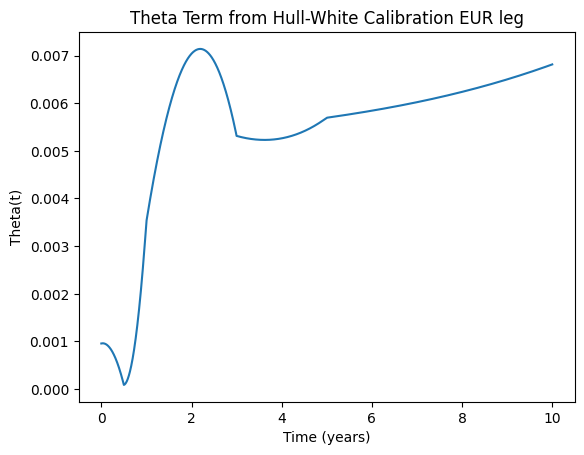

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), thetas)
plt.title("Theta Term from Hull-White Calibration EUR leg")
plt.xlabel("Time (years)")
plt.ylabel("Theta(t)")
plt.show()

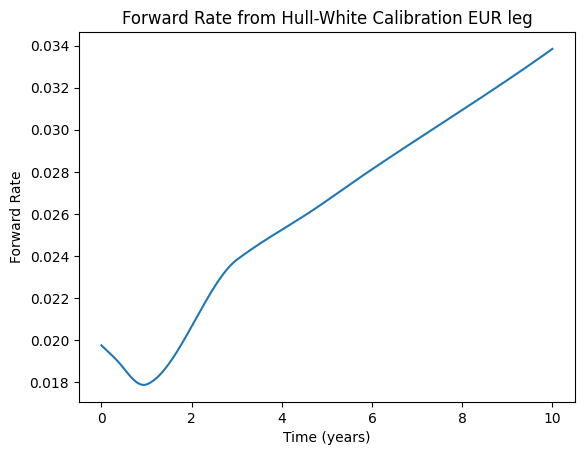

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), fwd)
plt.title("Forward Rate from Hull-White Calibration EUR leg")
plt.xlabel("Time (years)")
plt.ylabel("Forward Rate")
plt.show()

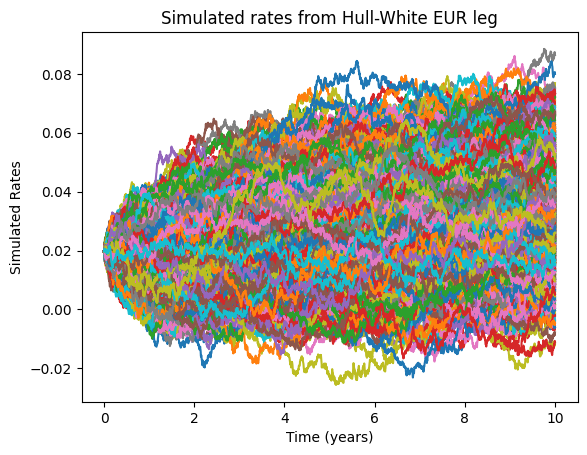

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), rates.values.T)
plt.title("Simulated rates from Hull-White EUR leg")
plt.xlabel("Time (years)")
plt.ylabel("Simulated Rates")
plt.show()

$USD\ Leg$

In [ ]:
#IR_USD=np.array([0.0424165, 0.04198963, 0.03970758, 0.03709815, 0.03842860, 0.04343447])#ZCB curve take from Refinitiv ticker 0#USXZ=R @04/08/2025
#IR_USD=np.array([0.04476652,0.04464766,0.04230291,0.03825963,0.03871780,0.04221793])#0#USDSBSLZ=R swap zero curve
IR_USD=np.array([0.04506990,0.04168691,0.03898887,0.03476108,0.03531262,0.03888371])#0#USDSROISZ=R USD SOFR OIS zero coupon yield curve
#IR_USD=np.array([0.04477063,0.04530056,0.04354118,0.03931743,0.03988087,0.04351643])#USDSBSLDZ=R US DOLLAR SB 6M LIBOR OIS DISCOUNTED ZERO CURVE
alfa_usd=0.17
sigma_usd=0.0075#

In [ ]:
thetas_USD,fwd_USD=theta_fit(Times,IR_USD,alfa_usd,sigma_usd,T,dt)
rates_USD=pd.DataFrame(H_W(IR_USD[0],thetas_USD,alfa_usd,sigma_usd,T,dt,n_path,seed=2))

In [ ]:
cs_usd=CubicSpline(Times,IR_USD,bc_type='natural')
IR6m_usd=cs_usd(Times6m)
disc_factors_usd=np.exp(-IR6m_usd*Times6m)#discount factor for the computation of the K rate

In [ ]:
rates6m_usd=rates_USD.iloc[:,daily_dates.astype(int)]
rates6m_usd.columns=Times6m

In [ ]:
MC_res_usd=[]
for t in Times:
    zrate=IR_USD[np.where(Times == t)[0][0]]
    PMK = np.exp(-IR_USD[np.where(Times == t)[0][0]] * t)
    t_idx = int(t / dt)
    integrals = np.zeros(rates_USD.shape[0])

    for i in range(rates_USD.shape[0]):

        integrals[i] = trapezoid(rates_USD.iloc[i, :t_idx+1], dx=dt)

    PMC = np.mean(np.exp(-integrals))
    MC_res_usd.append({ 'T (y)'   : t,
        'zero rate curve'   : zrate,
        'Martek Price'   : PMK,
        'Montecarlo Price'    : PMC,
        'Error'   : abs(PMC-PMK),
    })
df_MC_usd = pd.DataFrame(MC_res_usd)
print(df_MC_usd)

       T (y)  zero rate curve  Martek Price  Montecarlo Price         Error
0   0.083333         0.045070      0.996251          0.996308  5.698721e-05
1   0.500000         0.041687      0.979372          0.979735  3.623422e-04
2   1.000000         0.038989      0.961761          0.962379  6.179889e-04
3   3.000000         0.034761      0.900970          0.902064  1.093771e-03
4   5.000000         0.035313      0.838146          0.839352  1.206355e-03
5  10.000000         0.038884      0.677845          0.677845  4.113428e-07


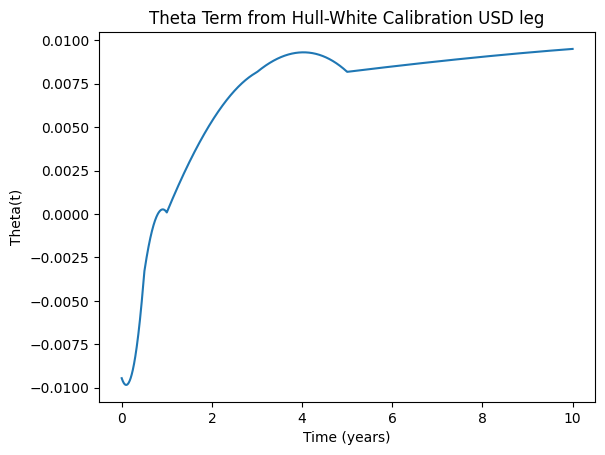

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), thetas_USD)
plt.title("Theta Term from Hull-White Calibration USD leg")
plt.xlabel("Time (years)")
plt.ylabel("Theta(t)")
plt.show()

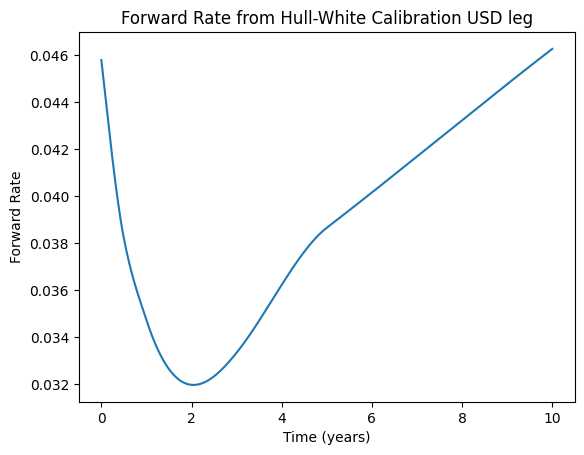

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), fwd_USD)
plt.title("Forward Rate from Hull-White Calibration USD leg")
plt.xlabel("Time (years)")
plt.ylabel("Forward Rate")
plt.show()

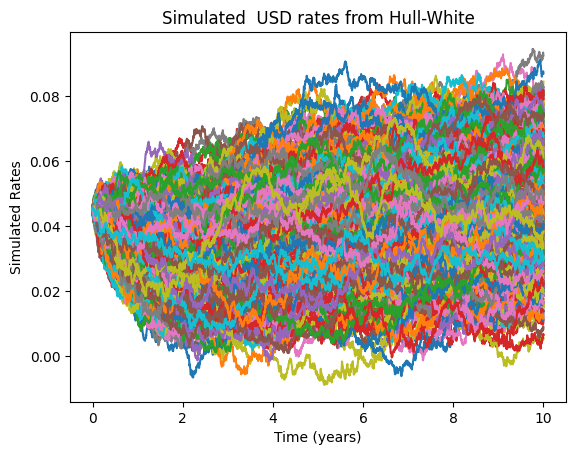

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), rates_USD.values.T)
plt.title("Simulated  USD rates from Hull-White")
plt.xlabel("Time (years)")
plt.ylabel("Simulated Rates")
plt.show()

$Optimization\ algo\ for\ \alpha\ and\ \sigma$

In [ ]:
'''def obj_function(params,Times,IR,n_path,T,dt):
  alfa,sigma=params
  thetas,fwd=theta_fit(Times,IR,alfa,sigma,T,dt)
  rates=pd.DataFrame(H_W(IR[0],thetas,alfa,sigma,T,dt,n_path))
  bond_prices=pd.DataFrame(BondPrices(sigma,alfa,IR,rates.values,T,0,Times))
  #BondPrice(fwd,alfa,T,dt,rates.to_numpy(),IR,Times,sigma)
  errors=[]

  for t in Times:
    mkt_price = np.exp(-IR[np.where(Times == t)[0][0]] * t)
    integral=np.zeros(rates.shape[0])
    t_idx = int(t / dt)
    for i in range(rates.shape[0]):
      integral[i]=cumulative_trapezoid(rates.iloc[i,:t_idx+1],dx=dt,initial=0)[-1]

    mc_price=np.mean(np.exp(-integral))
    errors.append((mkt_price-mc_price)**2)

  return np.mean(errors)

ig=[0.03,0.01]
bounds = [(0.001, 1.0), (0.001, 0.1)]  # reasonable ranges for alfa and sigma=[()]
result=minimize(obj_function,ig,args=(Times,IR,1000,T,dt),bounds=bounds)
optimal_alfa, optimal_sigma = result.x
print("Optimal alfa:", optimal_alfa)
print("Optimal sigma:", optimal_sigma)'''

'def obj_function(params,Times,IR,n_path,T,dt):\n  alfa,sigma=params\n  thetas,fwd=theta_fit(Times,IR,alfa,sigma,T,dt)\n  rates=pd.DataFrame(H_W(IR[0],thetas,alfa,sigma,T,dt,n_path))\n  bond_prices=pd.DataFrame(BondPrices(sigma,alfa,IR,rates.values,T,0,Times))\n  #BondPrice(fwd,alfa,T,dt,rates.to_numpy(),IR,Times,sigma)\n  errors=[]\n\n  for t in Times:\n    mkt_price = np.exp(-IR[np.where(Times == t)[0][0]] * t)\n    integral=np.zeros(rates.shape[0])\n    t_idx = int(t / dt)\n    for i in range(rates.shape[0]):\n      integral[i]=cumulative_trapezoid(rates.iloc[i,:t_idx+1],dx=dt,initial=0)[-1]\n\n    mc_price=np.mean(np.exp(-integral))\n    errors.append((mkt_price-mc_price)**2)\n\n  return np.mean(errors)\n\nig=[0.03,0.01]\nbounds = [(0.001, 1.0), (0.001, 0.1)]  # reasonable ranges for alfa and sigma=[()]\nresult=minimize(obj_function,ig,args=(Times,IR,1000,T,dt),bounds=bounds)\noptimal_alfa, optimal_sigma = result.x\nprint("Optimal alfa:", optimal_alfa)\nprint("Optimal sigma:", opti

#Plain Vanilla IRS

$Eur\ fixed\ vs\ floating\ IRS$

In [ ]:
K=swap_fixed_rate(disc_factors,0,Times6m)
swap_price=swap_price_func(disc_factors, K, 0, Times6m) #t=0
print(swap_price)

-1.1102230246251565e-16


In [ ]:
MtM = MtM_fun(alfa, sigma, IR6m, rates_6m.values, K, Times6m)
MtM_df = pd.DataFrame(MtM, columns=Times6m)
#MtM_df.iloc[:,0] = swap_price  # Set the first column to the price at t=0 using the actual term structure
MtM_df.head()

0.0       0.5       1.0       1.5       2.0       2.5       3.0       3.5   \
0   0.0 -0.016801 -0.046833 -0.051870 -0.056817  0.013602 -0.013551  0.011480   
1   0.0 -0.033458 -0.063029 -0.041228 -0.064041 -0.086643 -0.112653 -0.112150   
2   0.0  0.018578 -0.011852 -0.002188 -0.030950 -0.013718 -0.046100 -0.036278   
3   0.0  0.046842  0.033165  0.029933  0.009172  0.033025  0.029001 -0.006122   
4   0.0 -0.032373 -0.023830 -0.021704 -0.016727 -0.005701 -0.040162 -0.077863   

       4.0       4.5   ...      5.5       6.0       6.5       7.0       7.5   \
0  0.046143  0.005893  ...  0.032617  0.042379  0.029749  0.027334  0.017985   
1 -0.108480 -0.090580  ... -0.076571 -0.114808 -0.104297 -0.107208 -0.087426   
2 -0.008863 -0.005433  ... -0.042788 -0.051473 -0.052235 -0.036577 -0.039539   
3 -0.037508  0.005594  ...  0.034568  0.017997  0.002820 -0.007807 -0.014052   
4 -0.072064 -0.103400  ... -0.095653 -0.083546 -0.080122 -0.047581 -0.041622   

       8.0       8.5       9.0       9.5   10.0  
0  0.027306  0.014718  0.006198  0.007788   0.0  
1 -0.067189 -0.059285 -0.036259 -0.014152   0.0  
2 -0.037059 -0.033654 -0.018632 -0.004585   0.0  
3 -0.010041 -0.001019 -0.009342 -0.001268   0.0  
4 -0.027483 -0.016051 -0.020077 -0.008739   0.0  

[5 rows x 21 columns]

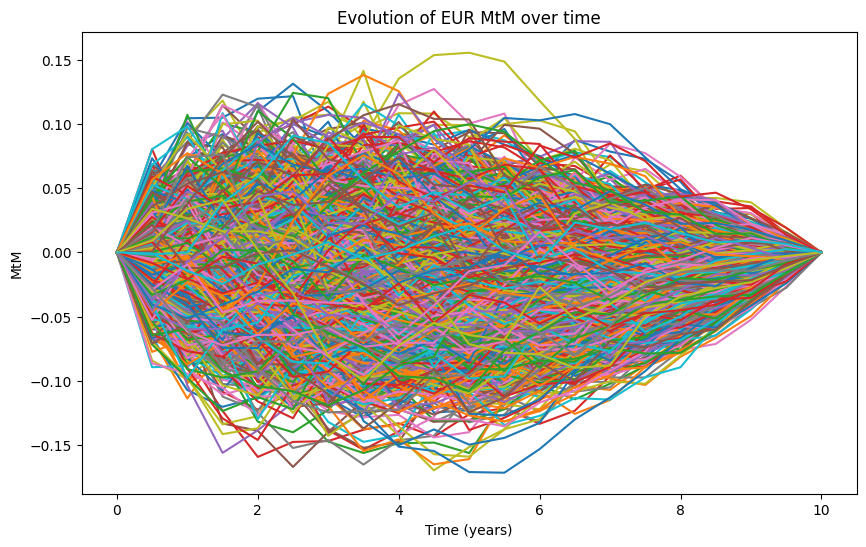

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(MtM_df.T)
plt.title("Evolution of EUR MtM over time")
plt.xlabel("Time (years)")
plt.ylabel("MtM")
plt.show()

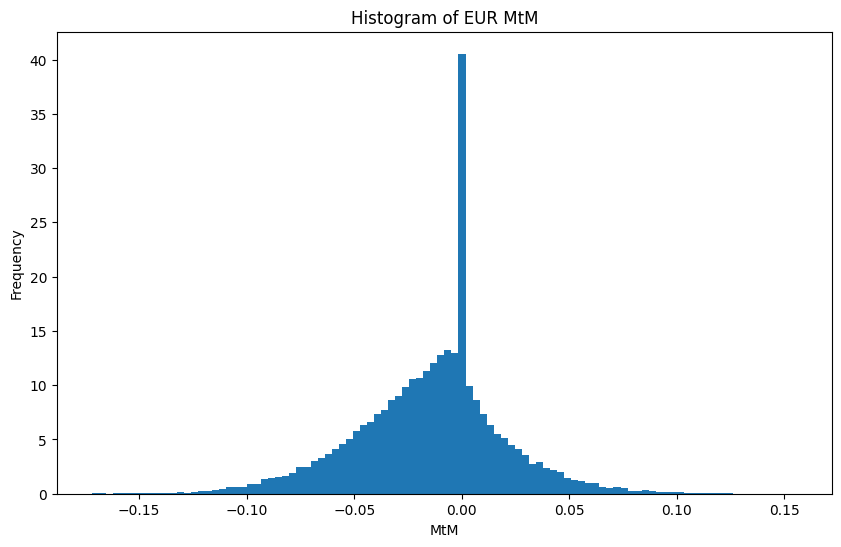

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(MtM_df.values.flatten(), bins=100, density=True)
plt.title("Histogram of EUR MtM")
plt.xlabel("MtM")
plt.ylabel("Frequency")
plt.show()

/tmp/ipython-input-2973342906.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=MtM_df.iloc[:,1:], bw_adjust=1, cut=0, linewidth=2)


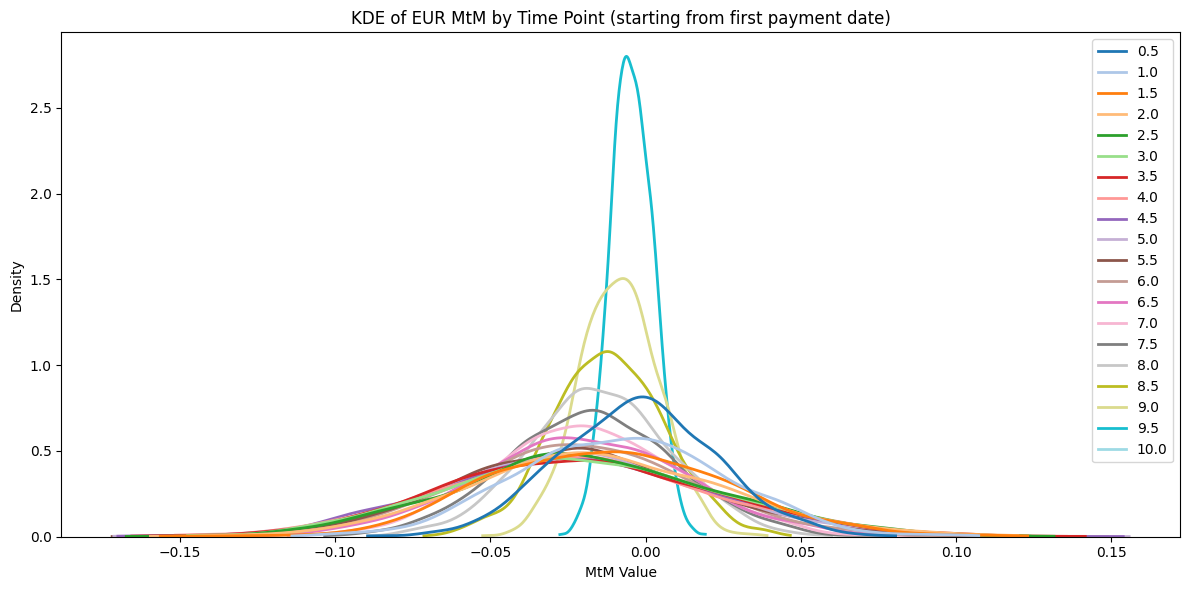

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_palette("tab20")
sns.kdeplot(data=MtM_df.iloc[:,1:], bw_adjust=1, cut=0, linewidth=2)
plt.title("KDE of EUR MtM by Time Point (starting from first payment date)")
plt.xlabel("MtM Value")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

$USD\ fixed\ vs\ floating\ IRS$

In [ ]:
K_usd=swap_fixed_rate(disc_factors_usd,0,Times6m)#Fixed rate that makes the swap fair at inception for the USD leg

In [ ]:
MtM_usd=MtM_fun(alfa_usd,sigma_usd,IR6m_usd,rates6m_usd.values,K_usd,Times6m)
MtM_usd_df=pd.DataFrame(MtM_usd,columns=Times6m)
MtM_usd_df.head()

0.0       0.5       1.0       1.5       2.0       2.5       3.0       3.5   \
0   0.0 -0.006203 -0.031285 -0.034190 -0.039205  0.020285 -0.005336  0.014385   
1   0.0 -0.020394 -0.045066 -0.024719 -0.045307 -0.066286 -0.090766 -0.091642   
2   0.0  0.023683 -0.001628  0.007974 -0.017808 -0.004264 -0.034159 -0.027267   
3   0.0  0.047398  0.036179  0.034645  0.015777  0.034803  0.029277 -0.002814   
4   0.0 -0.019478 -0.011480 -0.008323 -0.005035  0.002820 -0.028895 -0.063307   

       4.0       4.5   ...      5.5       6.0       6.5       7.0       7.5   \
0  0.042773  0.006817  ...  0.028826  0.036948  0.025499  0.023219  0.014773   
1 -0.089542 -0.074620  ... -0.063782 -0.098785 -0.089855 -0.093217 -0.075920   
2 -0.004667 -0.002588  ... -0.036462 -0.044627 -0.045671 -0.031960 -0.034991   
3 -0.031235  0.005646  ...  0.030052  0.015056  0.001330 -0.008247 -0.013893   
4 -0.059285 -0.087711  ... -0.081727 -0.071355 -0.068907 -0.040134 -0.035369   

       8.0       8.5       9.0       9.5   10.0  
0  0.023304  0.012086  0.004673  0.006648   0.0  
1 -0.058184 -0.051830 -0.031535 -0.012076   0.0  
2 -0.033076 -0.030256 -0.016693 -0.003969   0.0  
3 -0.010132 -0.001740 -0.009206 -0.001467   0.0  
4 -0.023132 -0.013325 -0.017621 -0.007633   0.0  

[5 rows x 21 columns]

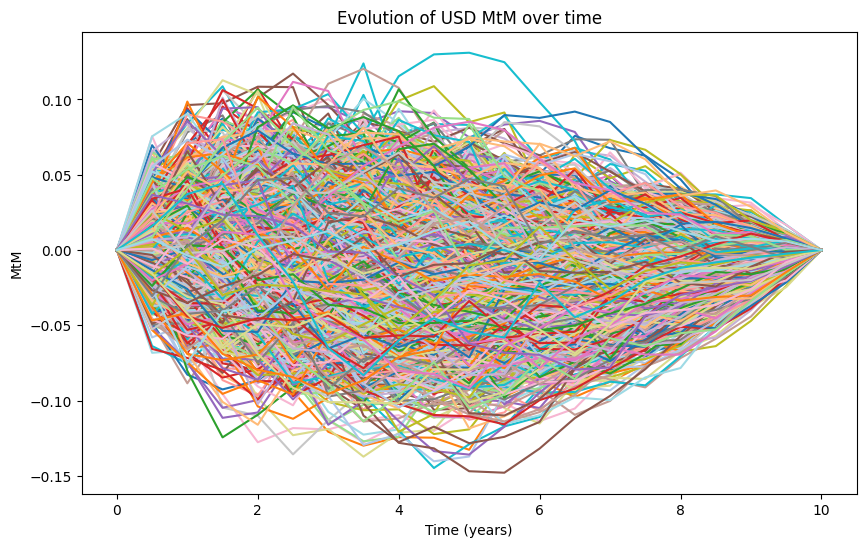

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(MtM_usd_df.T)
plt.title("Evolution of USD MtM over time")
plt.xlabel("Time (years)")
plt.ylabel("MtM")
plt.show()

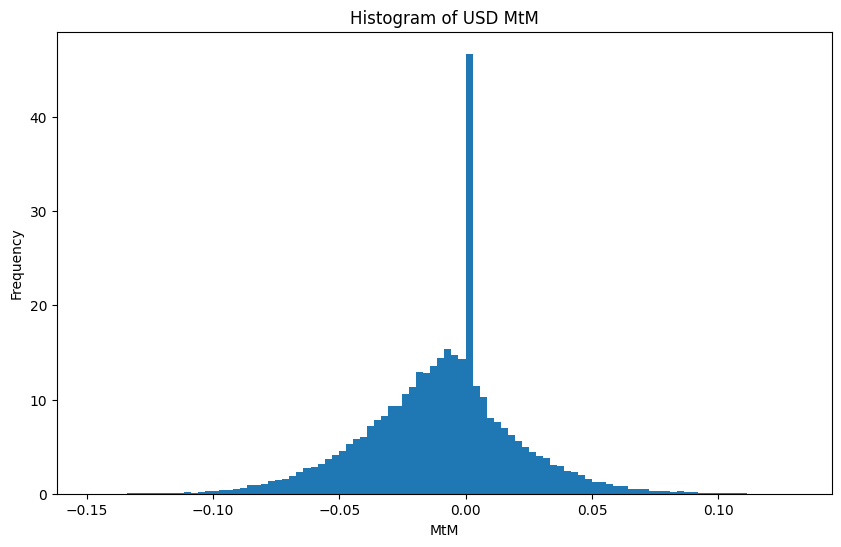

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(MtM_usd_df.values.flatten(), bins=100, density=True)
plt.title("Histogram of USD MtM")
plt.xlabel("MtM")
plt.ylabel("Frequency")
plt.show()

/tmp/ipython-input-2880136352.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=MtM_usd_df.iloc[:,1:], bw_adjust=1, cut=0, linewidth=2)


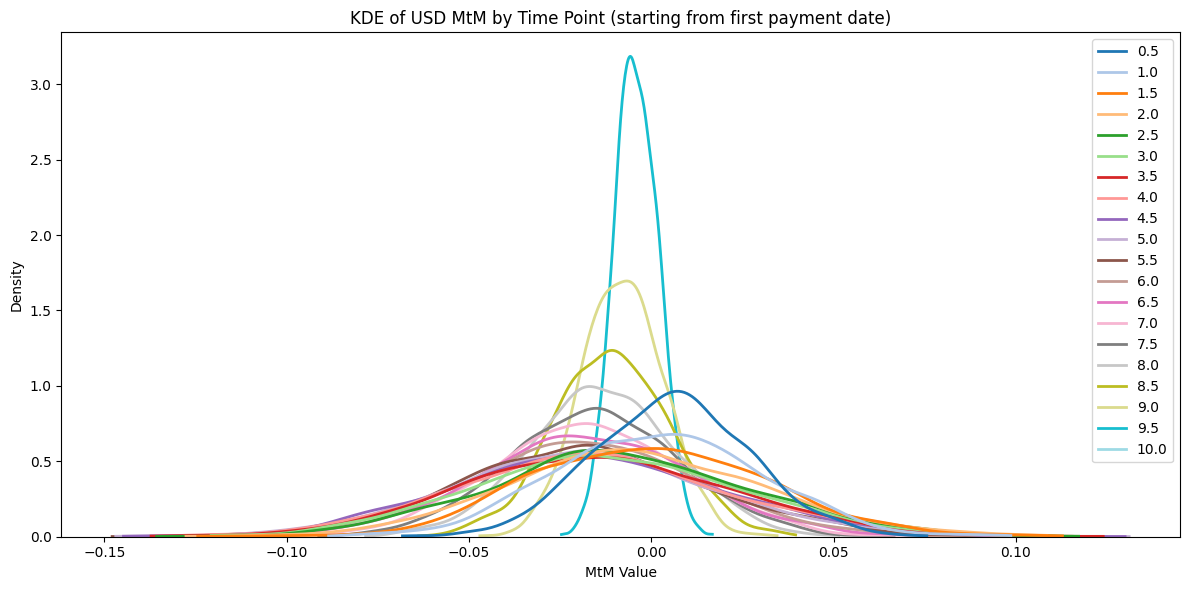

In [ ]:
plt.figure(figsize=(12, 6))
sns.set_palette("tab20")
sns.kdeplot(data=MtM_usd_df.iloc[:,1:], bw_adjust=1, cut=0, linewidth=2)
plt.title("KDE of USD MtM by Time Point (starting from first payment date)")
plt.xlabel("MtM Value")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

#XCCY Swap float vs float (receive EUR pay USD)

Retriving from market data the correlation matrix between eur interest rates,usd rates and EURUSD exchange rate

In [ ]:
'''# Dates
start = '2020-01-01'
end = '2025-08-15'

# Get FX from Yahoo (EUR/USD)
fx = yf.download('EURUSD=X', start=start, end=end)['Close']

# Get short rates from FRED
eur = web.DataReader('ECBESTRVOLWGTTRMDMNRT', 'fred', start, end)  # €STR
usd = web.DataReader('SOFR', 'fred', start, end)  # SOFR

# Compute differences and returns
eur_diff = eur.diff().dropna()
usd_diff = usd.diff().dropna()
fx_ret = np.log(fx / fx.shift(1)).dropna()

# Combine
df = pd.concat([eur_diff, usd_diff, fx_ret], axis=1)
df.columns = ['EUR_rate_diff', 'USD_rate_diff', 'FX_log_return']
df = df.dropna()

# Correlation matrix
corr_matrix = df.corr()
print("\n Correlation Matrix:\n", corr_matrix)'''

#below correlation matrix was extracted @16/08/2025
''' EUR_rate_diff  USD_rate_diff  FX_log_return
EUR_rate_diff       1.000000       0.001635      -0.045814
USD_rate_diff       0.001635       1.000000       0.049698
FX_log_return      -0.045814       0.049753       1.000000 '''

' EUR_rate_diff  USD_rate_diff  FX_log_return\nEUR_rate_diff       1.000000       0.001635      -0.045814\nUSD_rate_diff       0.001635       1.000000       0.049698\nFX_log_return      -0.045814       0.049753       1.000000 '

In order to avoid calling continuosly yahoo finance the correlation is stored below

In [ ]:
corr_values=[[1.0000,0.001635,-0.045814],
             [0.001635,1.0000,0.049753],
             [-0.045814,0.049753,1.0000]]
col_names=['EUR_rate_diff','USD_rate_diff','FX_log_ret']
corr_matrix=pd.DataFrame(corr_values,columns=col_names,index=col_names)

In [ ]:
eur_r_correlates,usd_r_correlated,fx_corr=fx_correlated(IR[0],IR_USD[0],thetas,thetas_USD,FX,corr_matrix,sigma_fx,mu_fx,sigma,alfa,alfa_usd,sigma_usd,T,dt,n_path,seed=3)#simulating the rates and fx with the correlation

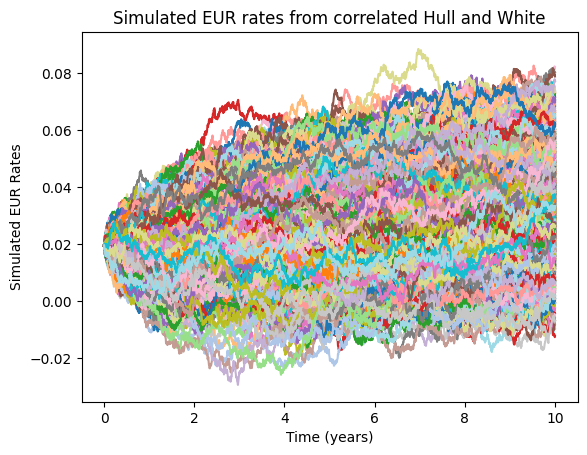

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), eur_r_correlates.values.T)
plt.title("Simulated EUR rates from correlated Hull and White")
plt.xlabel("Time (years)")
plt.ylabel("Simulated EUR Rates")
plt.show()

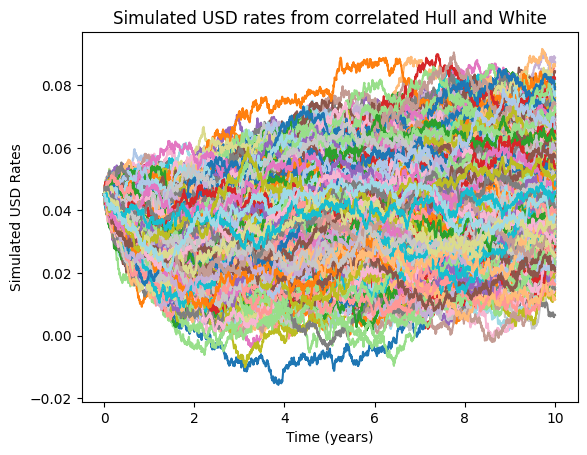

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), usd_r_correlated.values.T)
plt.title("Simulated USD rates from correlated Hull and White")
plt.xlabel("Time (years)")
plt.ylabel("Simulated USD Rates")
plt.show()

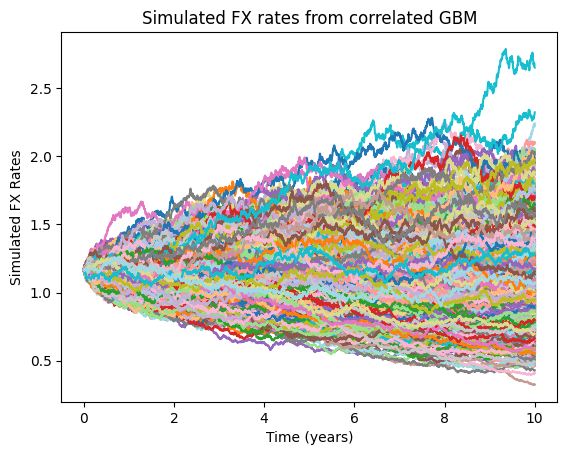

In [ ]:
plt.plot(np.linspace(0, T, int(T/dt)+1), fx_corr.values.T)
plt.title("Simulated FX rates from correlated GBM")
plt.xlabel("Time (years)")
plt.ylabel("Simulated FX Rates")
plt.show()

In [ ]:
eur6m_correlated=eur_r_correlates.iloc[:,daily_dates.astype(int)]
eur6m_correlated.columns=Times6m
usd6m_correlated=usd_r_correlated.iloc[:,daily_dates.astype(int)]
usd6m_correlated.columns=Times6m
fx6m_correlated=fx_corr.iloc[:,daily_dates.astype(int)]
fx6m_correlated.columns=Times6m

$XCCY\ without\ notional\ exchange$

In [ ]:
mtm_xccy_corr=xccy_mtm_exc(eur6m_correlated, usd6m_correlated, fx6m_correlated.values, Times6m, IR6m, IR6m_usd, sigma, alfa,sigma_usd,alfa_usd,notional_eur=1000000,notional_usd=1000000*FX,exchange=False)

In [ ]:
mtm_xccy_corr_df=pd.DataFrame(mtm_xccy_corr,columns=Times6m)

In [ ]:
mtm_xccy_corr_df

0.0            0.5            1.0            1.5            2.0   \
0      0.0 -140667.870862  -76031.077301 -131591.283010 -127929.662247   
1      0.0 -222920.164658 -162243.604701 -151952.226463 -126510.327922   
2      0.0 -107105.614225  -98399.037057 -111200.461358  -86679.814371   
3      0.0 -115348.432334  -61088.596529  -67683.645010  -64627.369344   
4      0.0 -120512.573461 -110676.656866 -134753.980560 -172023.103093   
...    ...            ...            ...            ...            ...   
1995   0.0 -149231.697260 -153446.839507 -193246.784041 -158787.513311   
1996   0.0  -80117.882669 -102820.729669 -129762.918625 -179394.899025   
1997   0.0  -90734.632823  -71068.082853  -96165.781257  -42230.378311   
1998   0.0 -147891.752295 -128441.264365 -199826.642492 -151720.719826   
1999   0.0 -166967.228897 -132798.263410 -127272.953521 -180941.838783   

               2.5            3.0            3.5            4.0   \
0     -66493.938135  -28572.111594  -25911.799683   10020.071878   
1     -62752.649845  -91657.056755 -103678.012700  -99580.306197   
2     -82836.430751   -1466.874983  -36879.932566  -33356.417404   
3    -100409.067554 -117051.264578 -110355.066928  -77422.322291   
4    -179697.107623 -223786.236180 -202055.014401 -139297.782021   
...             ...            ...            ...            ...   
1995 -198796.873825 -206832.197740 -205117.578407 -145111.870528   
1996 -268708.409562 -299670.387603 -294080.048981 -263388.696978   
1997  -85760.439805 -126698.397953 -157116.758873 -136126.940273   
1998 -148304.329899 -174839.157153 -143792.539167 -143524.746288   
1999 -154954.087220 -162058.085553 -206700.286717 -187128.650750   

               4.5   ...           5.5            6.0            6.5   \
0      -5970.280961  ...  -14398.424733  -21576.418384    9760.340363   
1    -123139.194814  ...  -62642.156007  -37448.579026  -54613.964651   
2     -60340.032454  ...  -59577.207187  -32031.049255  -15861.857477   
3     -79436.846451  ...  -18298.530652  -55680.058079  -65786.326155   
4     -92501.264155  ...  -65308.109993  -75467.359030  -37353.582277   
...             ...  ...            ...            ...            ...   
1995 -142725.123350  ... -106447.128147 -119621.721860 -112631.813418   
1996 -158362.828483  ...  -86627.958293  -77988.876287 -101904.574729   
1997 -138847.737816  ... -172229.879956 -159326.934636 -131171.405209   
1998 -126622.090285  ...  -72180.170816  -96982.289190  -73696.072751   
1999 -146980.385800  ... -182790.877563 -166976.544324 -130107.074231   

               7.0           7.5           8.0           8.5           9.0   \
0       9674.521247 -10182.238771   3196.162456  -4975.404128   9203.882884   
1    -102449.442694 -79770.856975 -85273.735729 -71490.313634 -35147.618713   
2     -39354.589810 -45830.023311 -13734.355821 -25755.729735 -11397.542676   
3     -16677.987464   9731.755930  13312.814300   7028.121690  -2115.935663   
4     -19553.449005 -10625.759809 -13404.051643 -13978.761576  -1129.997675   
...             ...           ...           ...           ...           ...   
1995  -78112.391169 -70616.544799 -66676.915999 -56055.080461 -45764.531678   
1996  -86563.850989 -97013.511808 -91186.189943 -65087.930592 -28270.620557   
1997 -102610.356765 -64973.049476 -36983.551799 -44931.091352 -33215.551588   
1998  -68832.584276 -51287.750737 -68285.997943 -36163.034281 -18189.730585   
1999 -125118.112336 -88259.361502 -47602.021909  -4722.431656 -10614.900971   

              9.5   10.0  
0      3514.100540   0.0  
1    -16025.592564   0.0  
2     -2824.318781   0.0  
3     -2352.891899   0.0  
4     -1112.630842   0.0  
...            ...   ...  
1995 -16139.246019   0.0  
1996 -15037.770144   0.0  
1997  -9880.339425   0.0  
1998  -6724.189337   0.0  
1999  -6552.265016   0.0  

[2000 rows x 21 columns]

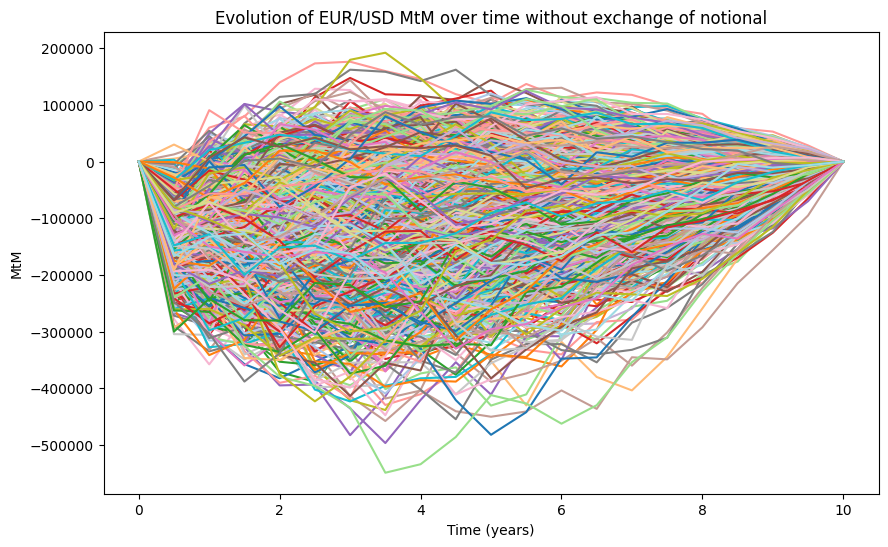

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mtm_xccy_corr_df.T)
plt.title("Evolution of EUR/USD MtM over time without exchange of notional")
plt.xlabel("Time (years)")
plt.ylabel("MtM")
plt.show()

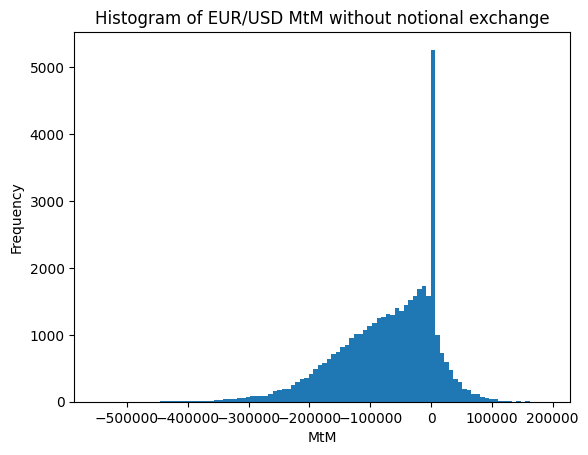

In [ ]:
plt.hist(mtm_xccy_corr_df.values.flatten(), bins=100, density=False)
plt.title("Histogram of EUR/USD MtM without notional exchange")
plt.ticklabel_format(style='plain',useOffset=False, axis='both')#turn off the scientific notation on the axis
plt.xlabel("MtM")
plt.ylabel("Frequency")
plt.show()

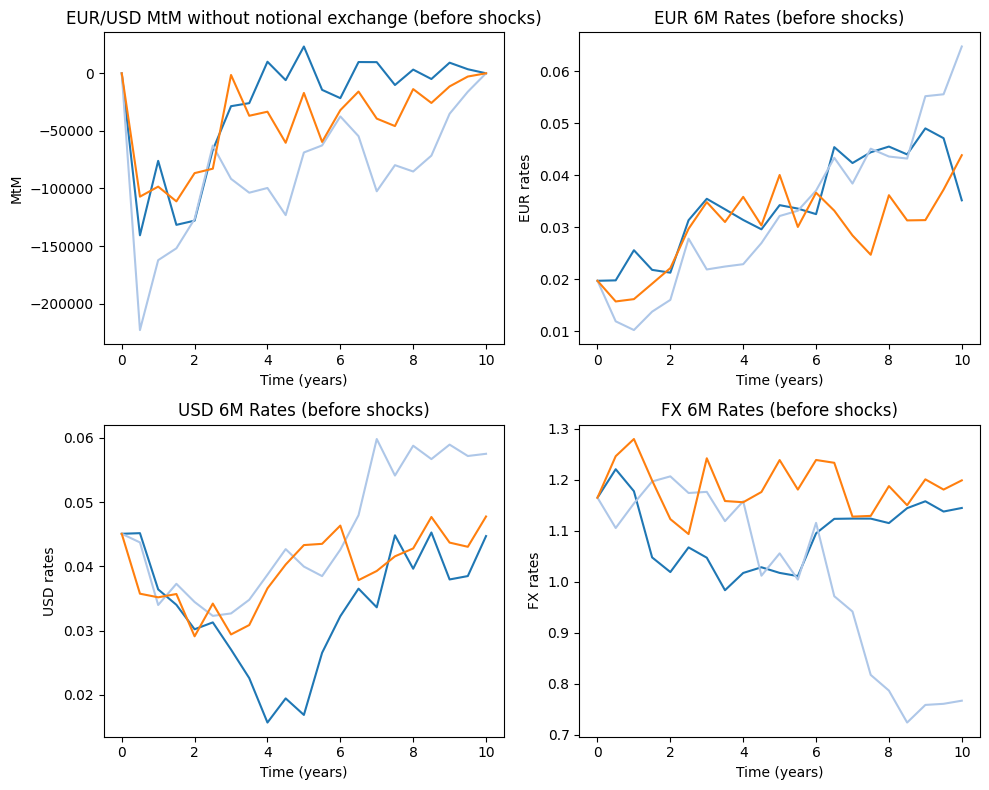

In [ ]:
# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Adjust size as needed

# First plot: EUR/USD MtM
axes[0][0].plot(mtm_xccy_corr_df.iloc[:3, :].T)
axes[0][0].set_title("EUR/USD MtM without notional exchange (before shocks)")
axes[0][0].set_xlabel("Time (years)")
axes[0][0].set_ylabel("MtM")

# Second plot: EUR rates
axes[0][1].plot(eur6m_correlated.iloc[:3, :].T)
axes[0][1].set_title("EUR 6M Rates (before shocks)")
axes[0][1].set_xlabel("Time (years)")
axes[0][1].set_ylabel("EUR rates")

# Third plot: USD rates
axes[1][0].plot(usd6m_correlated.iloc[:3, :].T)
axes[1][0].set_title("USD 6M Rates (before shocks)")
axes[1][0].set_xlabel("Time (years)")
axes[1][0].set_ylabel("USD rates")

# Fourth plot: FX 6M
axes[1][1].plot(fx6m_correlated.iloc[:3, :].T)
axes[1][1].set_title("FX 6M Rates (before shocks)")
axes[1][1].set_xlabel("Time (years)")
axes[1][1].set_ylabel("FX rates")

# Improve layout
plt.tight_layout()
plt.show()


$XCCY\ with\ notional\ exchange$

In [ ]:
mtm_xccy_corr_exc= xccy_mtm_exc(eur6m_correlated, usd6m_correlated, fx6m_correlated.values, Times6m, IR6m, IR6m_usd, sigma, alfa,sigma_usd,alfa_usd,notional_eur=1000000,notional_usd=1000000*FX,exchange=True)
mtm_xccy_corr_exc_df=pd.DataFrame(mtm_xccy_corr_exc,columns=Times6m)

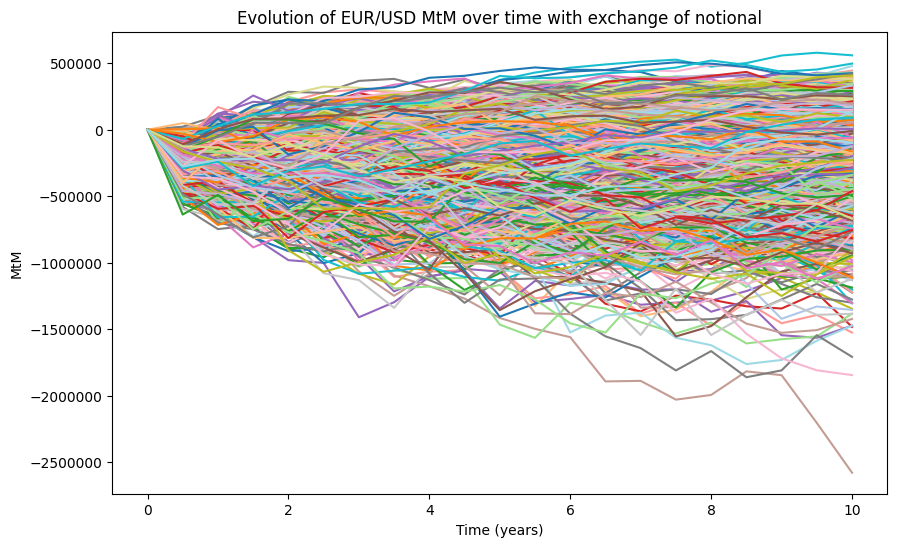

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mtm_xccy_corr_exc_df.T)
plt.title("Evolution of EUR/USD MtM over time with exchange of notional")
plt.ticklabel_format(style='plain',useOffset=False, axis='both')#turn off the scientific notation on the axis
plt.xlabel("Time (years)")
plt.ylabel("MtM")
plt.show()

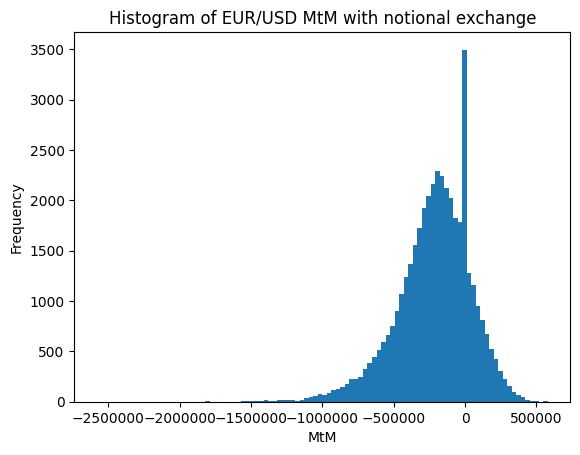

In [ ]:
plt.hist(mtm_xccy_corr_exc_df.values.flatten(), bins=100, density=False)
plt.title("Histogram of EUR/USD MtM with notional exchange")
plt.ticklabel_format(style='plain',useOffset=False, axis='both')#turn off the scientific notation on the axis
plt.xlabel("MtM")
plt.ylabel("Frequency")
plt.show()

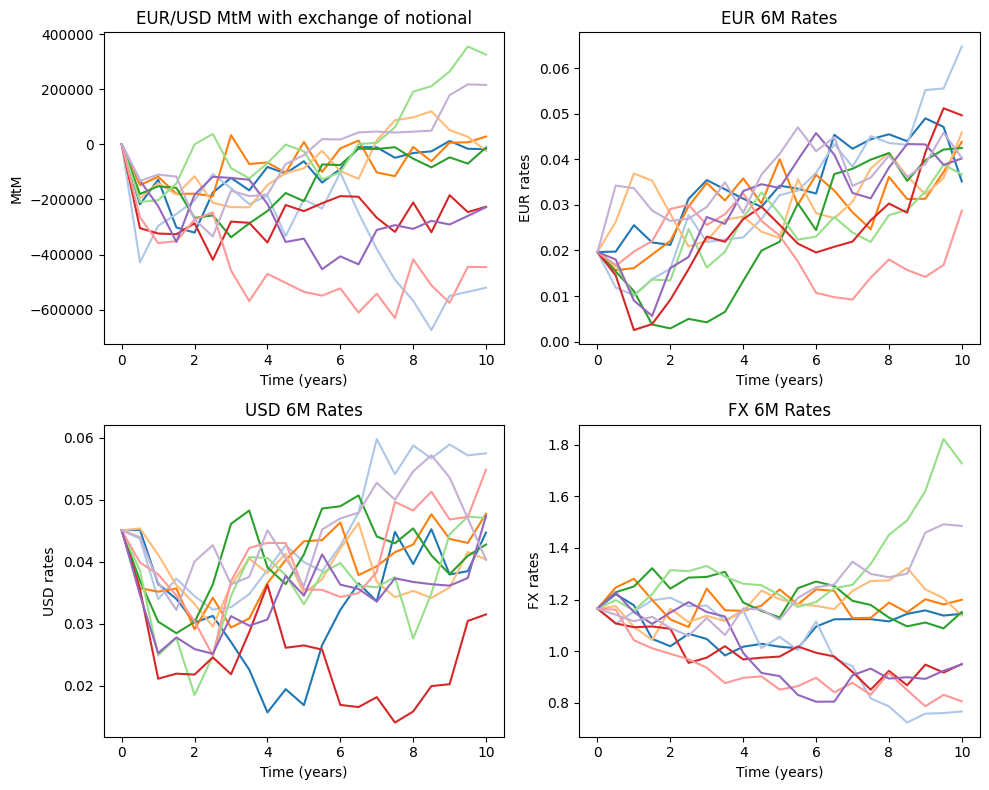

'IF EURUSD GOES UP IT MEANS THAT MY USD LIABILITY IS WORTH LESS IN EUR =)\n   IF EURUSD GOES DOWN IT MEANS THAT MY USD LIABILITY IS WORTH MORE IN EUR =('

In [ ]:
# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Adjust size as needed

# First plot: EUR/USD MtM
axes[0][0].plot(mtm_xccy_corr_exc_df.iloc[:10, :].T)
axes[0][0].set_title("EUR/USD MtM with exchange of notional")
axes[0][0].set_xlabel("Time (years)")
axes[0][0].set_ylabel("MtM")

# Second plot: EUR rates
axes[0][1].plot(eur6m_correlated.iloc[:10, :].T)
axes[0][1].set_title("EUR 6M Rates")
axes[0][1].set_xlabel("Time (years)")
axes[0][1].set_ylabel("EUR rates")

# Third plot: USD rates
axes[1][0].plot(usd6m_correlated.iloc[:10, :].T)
axes[1][0].set_title("USD 6M Rates")
axes[1][0].set_xlabel("Time (years)")
axes[1][0].set_ylabel("USD rates")

# Fourth plot: FX 6M
axes[1][1].plot(fx6m_correlated.iloc[:10, :].T)
axes[1][1].set_title("FX 6M Rates")
axes[1][1].set_xlabel("Time (years)")
axes[1][1].set_ylabel("FX rates")

# Improve layout
plt.tight_layout()
plt.show()

'''IF EURUSD GOES UP IT MEANS THAT MY USD LIABILITY IS WORTH LESS IN EUR =)
   IF EURUSD GOES DOWN IT MEANS THAT MY USD LIABILITY IS WORTH MORE IN EUR =('''

$Descriptive\ statistics\ for\ the\ XCCY\ without\ notional\ exchange\ after\ one\ year\ (before\ interest\ rates\ shock)$

In [ ]:
print(mtm_xccy_corr_df.iloc[:,np.searchsorted(Times6m,1)].describe())

count      2000.000000
mean    -122871.278856
std       66118.155233
min     -357959.907237
25%     -167587.793408
50%     -119325.879763
75%      -76279.988488
max       90661.241579
Name: 1.0, dtype: float64


$Descriptive\ statistics\ for\ the\ XCCY\ with\ notional\ exchange\ after\ one\ year\ (before\ interest\ rates\ shock)$

In [ ]:
print(mtm_xccy_corr_exc_df.iloc[:,np.searchsorted(Times6m,1)].describe())

count      2000.000000
mean    -234829.056338
std      143990.603018
min     -747241.679254
25%     -328113.890799
50%     -220496.061288
75%     -132730.661674
max      171070.043507
Name: 1.0, dtype: float64


$Average\ MtM\ across\ all\ paths\ over\ time$

In [ ]:
avg_mtm_over_time_exc = mtm_xccy_corr_exc_df.mean(axis=0) #with exchange
positive_years_exc = avg_mtm_over_time_exc[avg_mtm_over_time_exc > 0]#with this i find in which years the mtm of the swap is positive (if there are)
avg_mtm_over_time = mtm_xccy_corr_df.mean(axis=0) #withoud exchange
positive_years = avg_mtm_over_time[avg_mtm_over_time > 0]

In [ ]:
print('The average MtM for a xccy swap without notional exchange positve in the following years \n',positive_years)
print('The average MtM for a xccy swap with notional exchange positve in the following years \n',positive_years_exc)

The average MtM for a xccy swap without notional exchange positve in the following years 
 Series([], dtype: float64)
The average MtM for a xccy swap with notional exchange positve in the following years 
 Series([], dtype: float64)


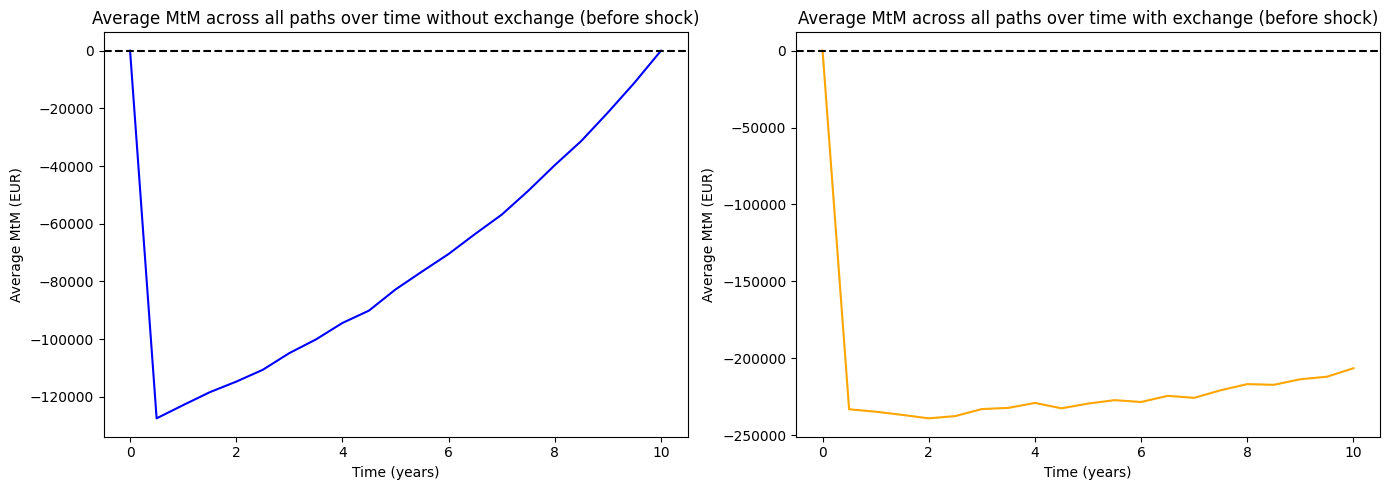

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

#without notional exchange
axes[0].plot(avg_mtm_over_time, color='blue')
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Average MtM (EUR)")
axes[0].set_title("Average MtM across all paths over time without exchange (before shock)")

#with notional exchange
axes[1].plot(avg_mtm_over_time_exc, color='orange')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_xlabel("Time (years)")
axes[1].set_ylabel("Average MtM (EUR)")
axes[1].set_title("Average MtM across all paths over time with exchange (before shock)")

plt.tight_layout()
plt.show()

#What if analysis

$Shocks$

In [ ]:
shock_euro=+0#Expressed in basis points
shock_usd=-100#Expressed in basis points

$After\ shocks$

In [ ]:
IR_S=IR+shock_euro/10000
IR_USD_S=IR_USD+shock_usd/10000

In [ ]:
eur_r_correlates_S = eur_r_correlates.copy()
usd_r_correlated_S = usd_r_correlated.copy()
fx_corr_S = fx_corr.copy()
if shock_euro!=0:
 thetas_S,_=theta_fit(Times,IR_S,alfa,sigma,T,dt)#EURO LEG
 eur_r_correlates_S=pd.DataFrame(H_W(IR_S[0],thetas_S,alfa,sigma,T,dt,n_path,seed=2))#EUR LEG

if shock_usd!=0:
 thetas_USD_S,_=theta_fit(Times,IR_USD_S,alfa_usd,sigma_usd,T,dt)#USD LEG
 usd_r_correlated_S=pd.DataFrame(H_W(IR_USD_S[0],thetas_USD_S,alfa_usd,sigma_usd,T,dt,n_path,seed=2))#USD LEG

_,_,fx_corr_S=fx_correlated(IR_S[0] if shock_euro!=0 else IR[0],
                            IR_USD_S[0] if shock_usd!=0 else IR_USD[0],
                            thetas_S if shock_euro !=0 else thetas,
                            thetas_USD_S if shock_usd!=0 else thetas_USD,
                            FX,corr_matrix,sigma_fx,mu_fx,sigma,alfa,alfa_usd,sigma_usd,T,dt,n_path,seed=3)#simulating the rates and fx with the correlation
#DATA EXTRACTION FOR THE BIANNUAL PAYMENT SCHEDULE
cs_S=CubicSpline(Times,IR_S,bc_type='natural')#EURO LEG
IR6m_S=cs_S(Times6m)#EURO LEG
cs_usd_S=CubicSpline(Times,IR_USD_S,bc_type='natural')#USD LEG
IR6m_usd_S=cs_usd_S(Times6m)#USD LEG

eur6m_correlated_S=eur_r_correlates_S.iloc[:,daily_dates.astype(int)]
eur6m_correlated_S.columns=Times6m
usd6m_correlated_S=usd_r_correlated_S.iloc[:,daily_dates.astype(int)]
usd6m_correlated_S.columns=Times6m
fx6m_correlated_S=fx_corr_S.iloc[:,daily_dates.astype(int)]
fx6m_correlated_S.columns=Times6m

In [ ]:
'''thetas_S,fwd_S=theta_fit(Times,IR_S,alfa,sigma,T,dt)#EURO LEG
thetas_USD_S,fwd_USD_S=theta_fit(Times,IR_USD_S,alfa_usd,sigma_usd,T,dt)#USD LEG

#SIMULATIONS OF INTEREST RATES AND FX RATES
eur_r_correlates_S,usd_r_correlated_S,fx_corr_S=fx_correlated(IR_S[0],IR_USD_S[0],thetas_S,thetas_USD_S,FX,corr_matrix,sigma_fx,mu_fx,sigma,alfa,alfa_usd,sigma_usd,T,dt,n_path)

#DATA EXTRACTION FOR THE BIANNUAL PAYMENT SCHEDULE
cs_S=CubicSpline(Times,IR_S,bc_type='natural')#EURO LEG
IR6m_S=cs_S(Times6m)#EURO LEG
cs_usd_S=CubicSpline(Times,IR_USD_S,bc_type='natural')#USD LEG
IR6m_usd_S=cs_usd_S(Times6m)#USD LEG

eur6m_correlated_S=eur_r_correlates_S.iloc[:,daily_dates.astype(int)]
eur6m_correlated_S.columns=Times6m
usd6m_correlated_S=usd_r_correlated_S.iloc[:,daily_dates.astype(int)]
usd6m_correlated_S.columns=Times6m
fx6m_correlated_S=fx_corr_S.iloc[:,daily_dates.astype(int)]
fx6m_correlated_S.columns=Times6m'''

"thetas_S,fwd_S=theta_fit(Times,IR_S,alfa,sigma,T,dt)#EURO LEG\nthetas_USD_S,fwd_USD_S=theta_fit(Times,IR_USD_S,alfa_usd,sigma_usd,T,dt)#USD LEG\n\n#SIMULATIONS OF INTEREST RATES AND FX RATES\neur_r_correlates_S,usd_r_correlated_S,fx_corr_S=fx_correlated(IR_S[0],IR_USD_S[0],thetas_S,thetas_USD_S,FX,corr_matrix,sigma_fx,mu_fx,sigma,alfa,alfa_usd,sigma_usd,T,dt,n_path)\n\n#DATA EXTRACTION FOR THE BIANNUAL PAYMENT SCHEDULE\ncs_S=CubicSpline(Times,IR_S,bc_type='natural')#EURO LEG\nIR6m_S=cs_S(Times6m)#EURO LEG\ncs_usd_S=CubicSpline(Times,IR_USD_S,bc_type='natural')#USD LEG\nIR6m_usd_S=cs_usd_S(Times6m)#USD LEG\n\neur6m_correlated_S=eur_r_correlates_S.iloc[:,daily_dates.astype(int)]\neur6m_correlated_S.columns=Times6m\nusd6m_correlated_S=usd_r_correlated_S.iloc[:,daily_dates.astype(int)]\nusd6m_correlated_S.columns=Times6m\nfx6m_correlated_S=fx_corr_S.iloc[:,daily_dates.astype(int)]\nfx6m_correlated_S.columns=Times6m"

$Simulation\ of\ MtM\ after\ shocks$

$Without\ notional\ exchange$

In [ ]:
mtm_xccy_corr_S=xccy_mtm_exc(eur6m_correlated_S, usd6m_correlated_S, fx6m_correlated_S.values, Times6m, IR6m_S, IR6m_usd_S, sigma, alfa,sigma_usd,alfa_usd,notional_eur=1000000,notional_usd=1000000*FX,exchange=False)

$With\ notional\ exchange$

In [ ]:
mtm_xccy_corr_exc_S=xccy_mtm_exc(eur6m_correlated_S, usd6m_correlated_S, fx6m_correlated_S.values, Times6m, IR6m_S, IR6m_usd_S, sigma, alfa,sigma_usd,alfa_usd,notional_eur=1000000,notional_usd=1000000*FX,exchange=True)

In [ ]:
mtm_xccy_corr_S_df=pd.DataFrame(mtm_xccy_corr_S,columns=Times6m)#MtM shocked without notional exchange
mtm_xccy_corr_exc_S_df=pd.DataFrame(mtm_xccy_corr_exc_S,columns=Times6m)#MtM shocked with notional exchange

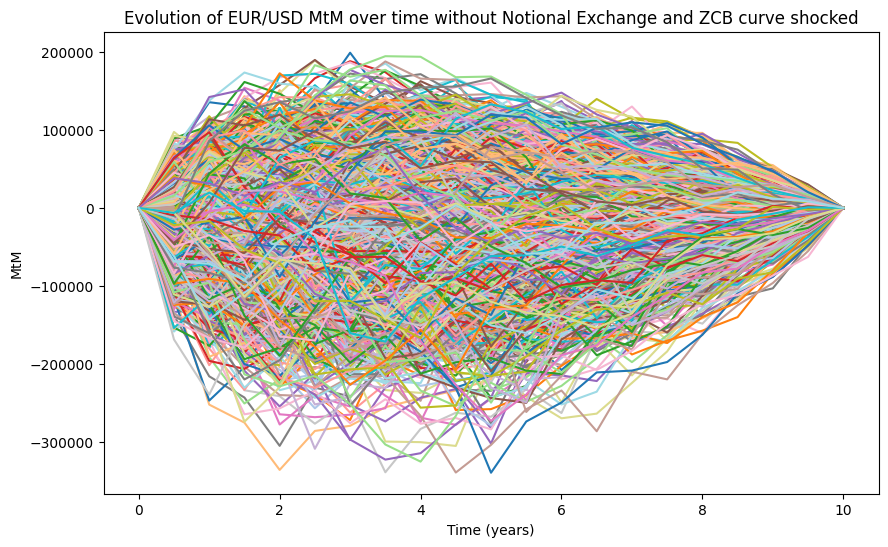

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(mtm_xccy_corr_S_df.T)
plt.title("Evolution of EUR/USD MtM over time without Notional Exchange and ZCB curve shocked")
plt.xlabel("Time (years)")
plt.ylabel("MtM")
plt.show()

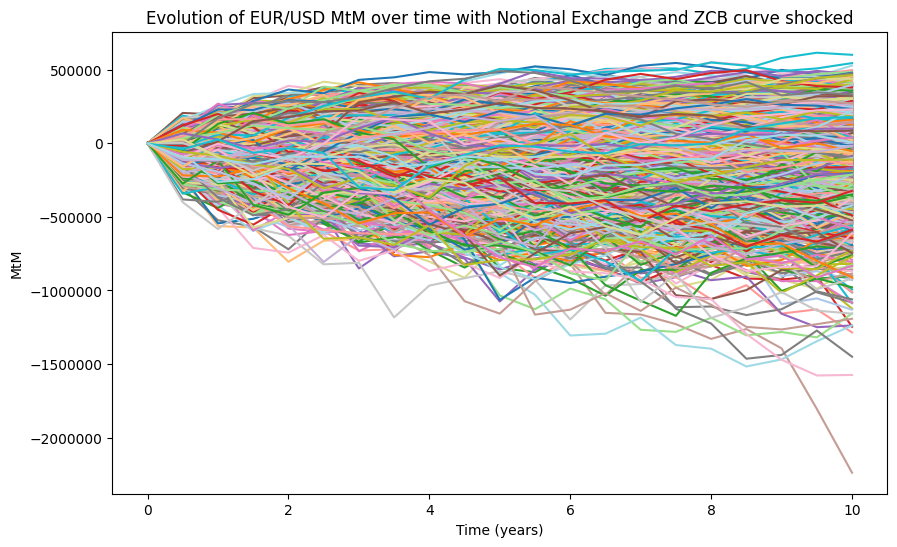

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mtm_xccy_corr_exc_S_df.T)
plt.title("Evolution of EUR/USD MtM over time with Notional Exchange and ZCB curve shocked")
plt.ticklabel_format(style='plain',useOffset=False, axis='both')#turn off the scientific notation on the axis
plt.xlabel("Time (years)")
plt.ylabel("MtM")
plt.show()

$"Zoom"\ on\ the\ first\ three\ simulation$

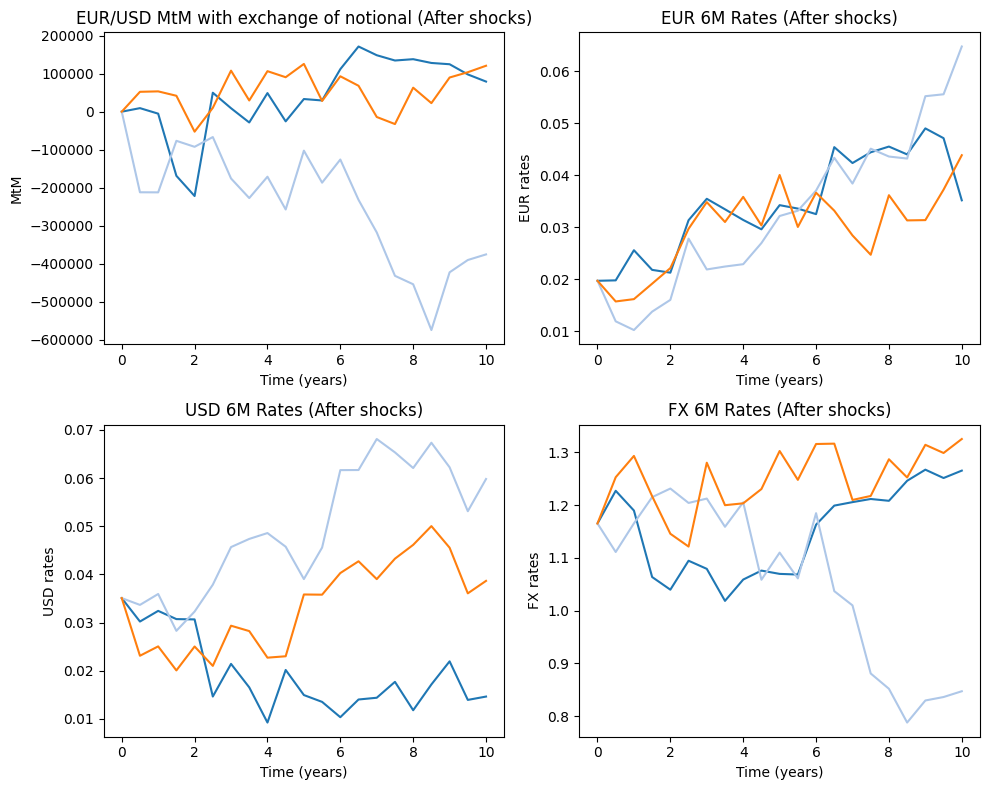

In [ ]:
# Create a figure with 2 rows and 2 columns
fig, axes = plt.subplots(2, 2, figsize=(10, 8))  # Adjust size as needed

# First plot: EUR/USD MtM
axes[0][0].plot(mtm_xccy_corr_exc_S_df.iloc[:3, :].T)
axes[0][0].set_title("EUR/USD MtM with exchange of notional (After shocks)")
axes[0][0].set_xlabel("Time (years)")
axes[0][0].set_ylabel("MtM")

# Second plot: EUR rates
axes[0][1].plot(eur6m_correlated_S.iloc[:3, :].T)
axes[0][1].set_title("EUR 6M Rates (After shocks)")
axes[0][1].set_xlabel("Time (years)")
axes[0][1].set_ylabel("EUR rates")

# Third plot: USD rates
axes[1][0].plot(usd6m_correlated_S.iloc[:3, :].T)
axes[1][0].set_title("USD 6M Rates (After shocks)")
axes[1][0].set_xlabel("Time (years)")
axes[1][0].set_ylabel("USD rates")

# Fourth plot: FX 6M
axes[1][1].plot(fx6m_correlated_S.iloc[:3, :].T)
axes[1][1].set_title("FX 6M Rates (After shocks)")
axes[1][1].set_xlabel("Time (years)")
axes[1][1].set_ylabel("FX rates")

# Improve layout
plt.tight_layout()
plt.show()

$Descriptive\ statistics\ for\ the\ XCCY\ without\ notional\ exchange\ after\ one\ year\ (after\ interest\ rates\ shock)$

In [ ]:
mtm_xccy_corr_S_df.iloc[:,np.searchsorted(Times6m,1)].describe()

count      2000.000000
mean     -20632.867994
std       57698.120406
min     -252289.160987
25%      -58673.112140
50%      -17561.090290
75%       19294.732270
max      142158.022834
Name: 1.0, dtype: float64

$Descriptive\ statistics\ for\ the\ XCCY\ with\ notional\ exchange\ after\ one\ year\ (after\ interest\ rates\ shock)$

In [ ]:
mtm_xccy_corr_exc_S_df.iloc[:,np.searchsorted(Times6m,1)].describe()

count      2000.000000
mean     -47892.765158
std      124373.401182
min     -582139.881399
25%     -122830.214255
50%      -39170.889705
75%       41772.757346
max      270134.373144
Name: 1.0, dtype: float64

In [ ]:
avg_mtm_over_time_exc_S = mtm_xccy_corr_exc_S_df.mean(axis=0) #with exchange
positive_years_exc_S = avg_mtm_over_time_exc_S[avg_mtm_over_time_exc_S > 0]#with this i find in which years the mtm of the swap is positive (if there are)
avg_mtm_over_time_S = mtm_xccy_corr_S_df.mean(axis=0) #without exchange
positive_years_S = avg_mtm_over_time_S[avg_mtm_over_time_S > 0]

In [ ]:
print('The average MtM for a xccy swap without notional exchange positve in the following years \n',positive_years_S)
print('The average MtM for a xccy swap with notional exchange positve in the following years \n',positive_years_exc_S)

The average MtM for a xccy swap without notional exchange positve in the following years 
 Series([], dtype: float64)
The average MtM for a xccy swap with notional exchange positve in the following years 
 Series([], dtype: float64)


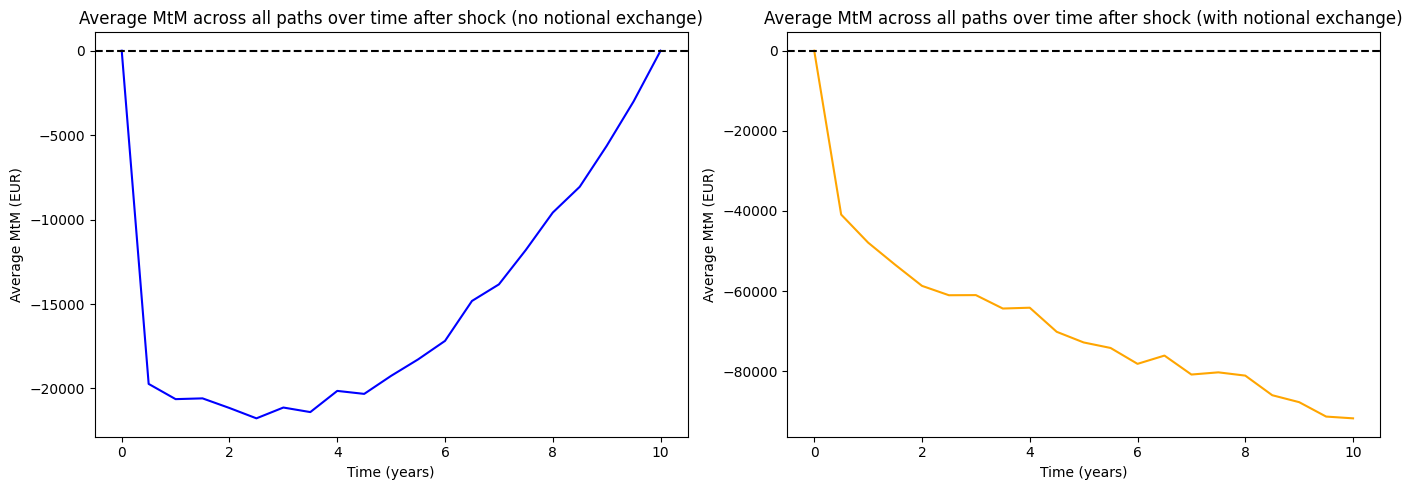

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(14,5))

#without notional exchange
axes[0].plot(avg_mtm_over_time_S, color='blue')
axes[0].axhline(0, color='black', linestyle='--')
axes[0].set_xlabel("Time (years)")
axes[0].set_ylabel("Average MtM (EUR)")
axes[0].set_title("Average MtM across all paths over time after shock (no notional exchange)")

#with notional exchange
axes[1].plot(avg_mtm_over_time_exc_S, color='orange')
axes[1].axhline(0, color='black', linestyle='--')
axes[1].set_xlabel("Time (years)")
axes[1].set_ylabel("Average MtM (EUR)")
axes[1].set_title("Average MtM across all paths over time after shock (with notional exchange)")

plt.tight_layout()
plt.show()

$comparison\ between\ all\ cases$

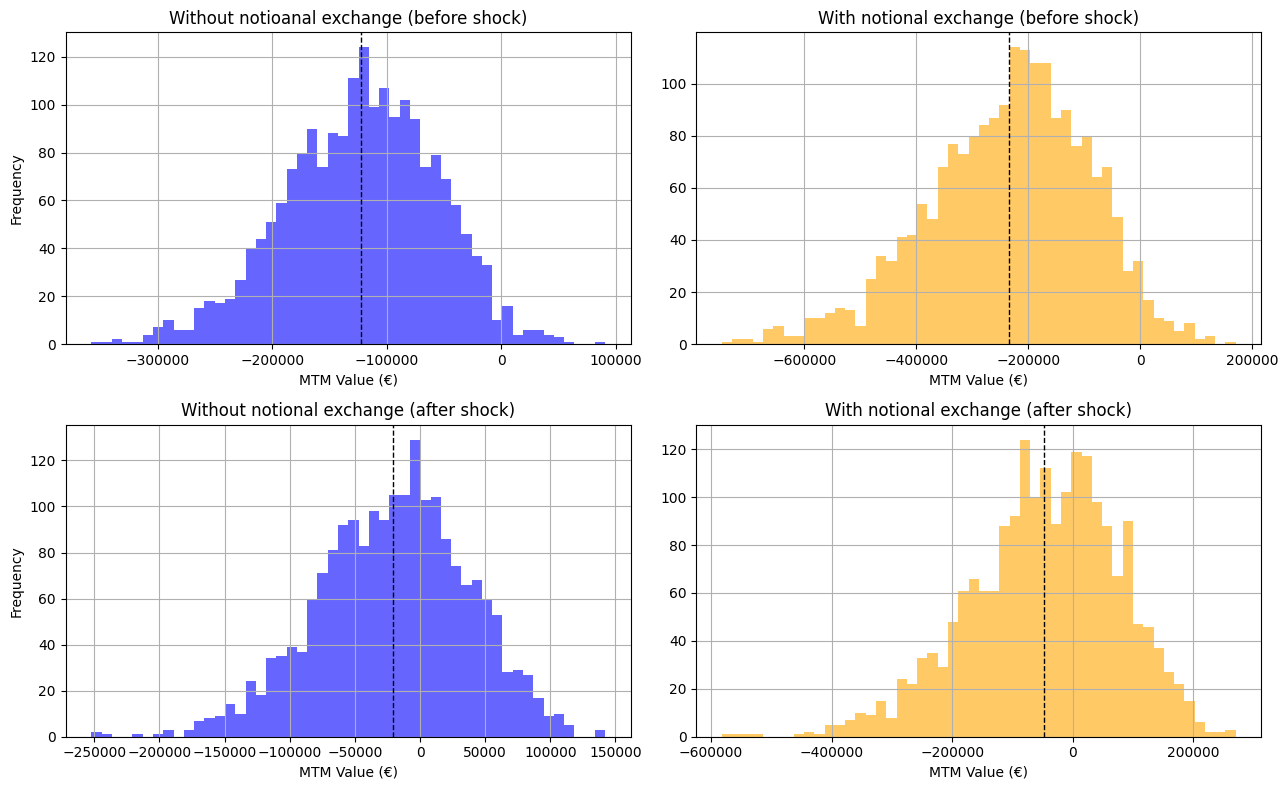

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(13,8))
#DISTRIBUTION OF MTM AFTER ONE YEAR BEFORE SHOCKS
# Without exchange
axes[0][0].hist(mtm_xccy_corr_df.iloc[:, np.searchsorted(Times6m, 1)].to_numpy().flatten(),
             bins=50, alpha=0.6, color='blue', density=False)
axes[0][0].axvline(mtm_xccy_corr_df.iloc[:, np.searchsorted(Times6m, 1)].mean(),
                color='black', linestyle='--', linewidth=1)
axes[0][0].set_title("Without notioanal exchange (before shock)")
axes[0][0].set_xlabel("MTM Value (€)")
axes[0][0].set_ylabel("Frequency")
axes[0][0].grid(True)

# With exchange
axes[0][1].hist(mtm_xccy_corr_exc_df.iloc[:, np.searchsorted(Times6m, 1)].to_numpy().flatten(),
             bins=50, alpha=0.6, color='orange', density=False)
axes[0][1].axvline(mtm_xccy_corr_exc_df.iloc[:, np.searchsorted(Times6m, 1)].mean(),
                color='black', linestyle='--', linewidth=1)
axes[0][1].set_title("With notional exchange (before shock)")
axes[0][1].set_xlabel("MTM Value (€)")
axes[0][1].grid(True)
#DISTRIBUTION OF MTM AFTER ONE YEAR AFTER SHOCKS
#wihout exchange
axes[1][0].hist(mtm_xccy_corr_S_df.iloc[:, np.searchsorted(Times6m, 1)].to_numpy().flatten(),
             bins=50, alpha=0.6, color='blue', density=False)
axes[1][0].axvline(mtm_xccy_corr_S_df.iloc[:, np.searchsorted(Times6m, 1)].mean(),
                color='black', linestyle='--', linewidth=1)
axes[1][0].set_title("Without notional exchange (after shock)")
axes[1][0].set_xlabel("MTM Value (€)")
axes[1][0].set_ylabel("Frequency")
axes[1][0].grid(True)

# With exchange after one year
axes[1][1].hist(mtm_xccy_corr_exc_S_df.iloc[:, np.searchsorted(Times6m, 1)].to_numpy().flatten(),
             bins=50, alpha=0.6, color='orange', density=False)
axes[1][1].axvline(mtm_xccy_corr_exc_S_df.iloc[:, np.searchsorted(Times6m, 1)].mean(),
                color='black', linestyle='--', linewidth=1)
axes[1][1].set_title("With notional exchange (after shock)")
axes[1][1].set_xlabel("MTM Value (€)")
axes[1][1].grid(True)

plt.tight_layout()
plt.show()

$Value\ at\ Risk\ at\ 95\%$

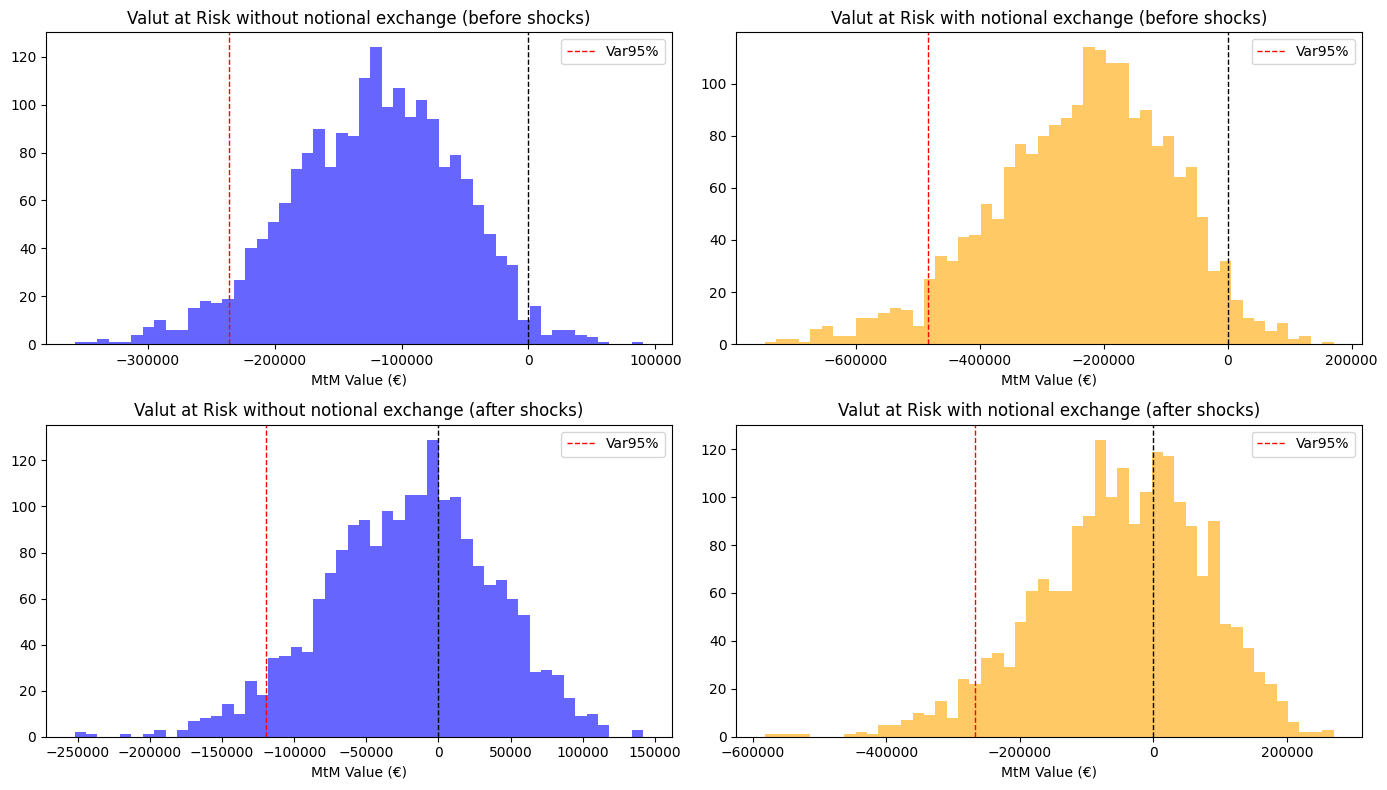

In [ ]:
fig,axes=plt.subplots(2,2,figsize=(14,8))
#BEFORE SHOCK NO EXCHANGE OF NOTIONAL
var1=np.percentile(mtm_xccy_corr_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5)
axes[0][0].hist(mtm_xccy_corr_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),bins=50,alpha=0.6,color='blue',density=False)#AFTER 1YEAR
axes[0][0].axvline(np.percentile(mtm_xccy_corr_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5),color='red',linestyle='--',linewidth=1,label="Var95%")
axes[0][0].axvline(0,color='black',linestyle='--',linewidth=1,)
axes[0][0].set_title('Valut at Risk without notional exchange (before shock)')
axes[0][0].set_xlabel('MtM Value (€)')
axes[0][0].legend()
#BEFORE SHOCK WITH EXCHANGE OF NOTIONAL
axes[0][1].hist(mtm_xccy_corr_exc_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),bins=50,alpha=0.6,color='orange',density=False)#AFTER 1YEAR
axes[0][1].axvline(np.percentile(mtm_xccy_corr_exc_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5),color='red',linestyle='--',linewidth=1, label="Var95%")
axes[0][1].axvline(0,color='black',linestyle='--',linewidth=1,)
axes[0][1].set_title('Valut at Risk with notional exchange (before shock)')
axes[0][1].set_xlabel('MtM Value (€)')
axes[0][1].legend()
#AFTER SHOCK WITHOUT EXCHANGE OF NOTIONAL
axes[1][0].hist(mtm_xccy_corr_S_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),bins=50,alpha=0.6,color='blue',density=False)#AFTER 1YEAR
axes[1][0].axvline(np.percentile(mtm_xccy_corr_S_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5),color='red',linestyle='--',linewidth=1,label="Var95%")
axes[1][0].axvline(0,color='black',linestyle='--',linewidth=1,)
axes[1][0].set_title('Valut at Risk without notional exchange (after shock)')
axes[1][0].set_xlabel('MtM Value (€)')
axes[1][0].legend()
#AFTER SHOCK WITH EXCHANGE OF NOTIONAL
axes[1][1].hist(mtm_xccy_corr_exc_S_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),bins=50,alpha=0.6,color='orange',density=False)#AFTER 1YEAR
axes[1][1].axvline(np.percentile(mtm_xccy_corr_exc_S_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5),color='red',linestyle='--',linewidth=1,label="Var95%")
axes[1][1].axvline(0,color='black',linestyle='--',linewidth=1,)
axes[1][1].set_title('Valut at Risk with notional exchange (after shock)')
axes[1][1].set_xlabel('MtM Value (€)')
axes[1][1].legend()

plt.tight_layout()
plt.show()

In [ ]:
var1=np.percentile(mtm_xccy_corr_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5)#var after 1 year at 95% of the xccy without notional exchange before shock
var1_exc=np.percentile(mtm_xccy_corr_exc_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5)#var after 1 year at 95% of the xccy with notional exchange before shock
var2=np.percentile(mtm_xccy_corr_S_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5)#var after 1 year at 95% of the xccy without notional exchange after shock
var2_exc=np.percentile(mtm_xccy_corr_exc_S_df.iloc[:,np.searchsorted(Times6m, 1)].to_numpy().flatten(),5)#var after 1 year at 95% of the xccy with notional exchange after shock

print(f"VaR (95%) | XCCY w/o notional exchange (before shock): {var1:.3f}")
print(f"VaR (95%) | XCCY with notional exchange (before shock): {var1_exc:.3f}")
print(f"VaR (95%) | XCCY w/o notional exchange (after shock): {var2:.3f}")
print(f"VaR (95%) | XCCY with notional exchange (after shock): {var2_exc:.3f}")


VaR (95%) | XCCY w/o notional exchange (before shock): -236547.286
VaR (95%) | XCCY with notional exchange (before shock): -482857.435
VaR (95%) | XCCY w/o notional exchange (after shock): -119285.126
VaR (95%) | XCCY with notional exchange (after shock): -267313.254
